# Część praktyczna pracy magisterskiej

##############################################################################################
### Import bibliotek
##############################################################################################

In [3]:
import os
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import umap 

from keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, Flatten, Input,  Dot,Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.utils import model_to_dot, get_file
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.constraints import NonNeg
from IPython.display import SVG

import r_metrics
import recmetrics

##############################################################################################
### Wczytanie i edycja zbioru movielens
##############################################################################################

In [ ]:
# # Pobieranie zbioru danych ze strony grouplens.org 
# Odkomentować jeśli zbiory mają zostać pobrane!
# ml_latest_small_url = ("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")

# ml_25m_url = ("https://files.grouplens.org/datasets/movielens/ml-25m.zip")

# cwd = os.getcwd()

# ml_latest_small_url_zipped = get_file(cwd+"\\"+"ml-latest-small.zip", ml_latest_small_url)
# ml_25m_url_zipped = get_file(cwd+"\\"+"ml-25m.zip", ml_25m_url)

# # Wypakowywanie ml_latest_small_url
# with ZipFile(ml_latest_small_url_zipped, "r") as zip:
#         # Wypakowywanie pliku
#         print("Wypakowywanie pliku...")
#         zip.extractall(path=cwd)
#         print("Done!")
# # Wypakowywanie ml_25m_url
# with ZipFile(ml_25m_url_zipped, "r") as zip:
#         # Wypakowywanie pliku
#         print("Wypakowywanie pliku...")
#         zip.extractall(path=cwd)
#         print("Done!")

In [27]:
ratings_df = pd.read_csv('./ml-latest-small/ratings.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies_df = pd.read_csv('./ml-latest-small/movies.csv', header=0, names=['movie_id', 'title', 'genres'])
tags_df = pd.read_csv('./ml-latest-small/tags.csv', header=0, names=['user_id', 'movie_id', 'tag', 'timestamp'])

genome_scores = pd.read_csv('./ml-25m/genome-scores.csv', header=0, names=['movie_id', 'tag_id', 'relevance'])
genome_tags = pd.read_csv('./ml-25m/genome-tags.csv', header=0, names=['tag_id', 'tag'])

# Unikalne filmy w zbiorze tagów genome_scores
genome_scores_unique_movies = genome_scores.movie_id.unique()
# Unikalne filmy w zbiorze ocen
ratings_df_unique_movies = ratings_df.movie_id.unique()

In [9]:
ratings_df

,user_id,movie_id,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [11]:
movies_df

,movie_id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [12]:
genome_scores

,movie_id,tag_id,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075
...,...,...,...
15584443,206499,1124,0.11000
15584444,206499,1125,0.04850
15584445,206499,1126,0.01325
15584446,206499,1127,0.14025


In [13]:
genome_tags

,tag_id,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [28]:
# Sprawdzenie ile z filmów w zbiorze ratings_df nie posiada tagów w zbiorze genome_scores
diff = np.isin(ratings_df_unique_movies,genome_scores_unique_movies)
diff = pd.DataFrame({'movie_id': ratings_df_unique_movies, 'present': diff})
diff = diff[diff["present"] == False]
print("Liczba filmów w zbiorze ratings_df bez tagów: ", len(diff))

# Liczba unikalnych użytkowników i filmów przed usuwaniem filmów bez tagów
print("Liczba unikalnych użytkowników przed usuwaniem filmów bez tagów: ", len(ratings_df.user_id.unique()))
print("Liczba unikalnych filmów przed usuwaniem filmów bez tagów: ", len(ratings_df.movie_id.unique()))

# Usunięcie filmów ze zbioru ratings_df nieposiadających tagów w zbiorze genome_scores
ratings_df = ratings_df[ratings_df["movie_id"].isin(genome_scores_unique_movies)]
# Usunięcie filmów ze zbioru genome_scores nieobecnych w zbiorze ratings_df
genome_scores = genome_scores[genome_scores["movie_id"].isin(ratings_df.movie_id.unique())]

# Liczba unikalnych użytkowników i filmów po usuwaniu filmów bez tagów
print("Liczba unikalnych użytkowników po usuwaniu filmów bez tagów: ", len(ratings_df.user_id.unique()))
print("\nLiczba unikalnych filmów po usuwaniu filmów bez tagów: ", len(ratings_df.movie_id.unique()))

Liczba filmów w zbiorze ratings_df bez tagów:  1073
Liczba unikalnych użytkowników przed usuwaniem filmów bez tagów:  610
Liczba unikalnych filmów przed usuwaniem filmów bez tagów:  9724
Liczba unikalnych użytkowników po usuwaniu filmów bez tagów:  610

Liczba unikalnych filmów po usuwaniu filmów bez tagów:  8651


In [29]:
# # ID filmów ze zbioru MovieLens są ponumerowane w sposób utrudniający ich przetwarzanie (movie_id:1,3,6,50,101,223...),
# Zmiana numeracji movie_id
fixed_movie_id_list = list(ratings_df["movie_id"])

old_to_new_id_dict = dict()

new_index = 0
for index, movie_id in enumerate(fixed_movie_id_list):
    if old_to_new_id_dict.get(movie_id) == None:
        old_to_new_id_dict[movie_id] = new_index
        fixed_movie_id_list[index] = new_index
        new_index += 1
    else:
        fixed_movie_id_list[index] = old_to_new_id_dict[movie_id]

ratings_df["old_movie_id"] = ratings_df["movie_id"] 
ratings_df["movie_id"] = fixed_movie_id_list

#Zmiana numeracji ID użytkowników na zaczynające się od 0 w ratings_df
ratings_df["user_id"] = ratings_df["user_id"].apply(lambda x: x-1)

ratings_df = ratings_df.reset_index(drop = True)

In [24]:
ratings_df

,user_id,movie_id,rating,timestamp,old_movie_id
0,0,0,4.0,964982703,1
1,0,1,4.0,964981247,3
2,0,2,4.0,964982224,6
3,0,3,5.0,964983815,47
4,0,4,5.0,964982931,50
...,...,...,...,...,...
99439,609,3038,4.0,1493848402,166534
99440,609,1986,5.0,1493850091,168248
99441,609,3039,5.0,1494273047,168250
99442,609,1368,5.0,1493846352,168252


In [30]:
# Normalizacja ocen w zbiorze ratings_df
ratings_df["old_rating"] = ratings_df["rating"]
ratings_df["rating"] = MinMaxScaler(feature_range=(0,1)).fit_transform(ratings_df[["rating"]])

In [172]:
ratings_df

,user_id,movie_id,rating,timestamp,old_movie_id,old_rating
0,0,0,0.777778,964982703,1,4.0
1,0,1,0.777778,964981247,3,4.0
2,0,2,0.777778,964982224,6,4.0
3,0,3,1.000000,964983815,47,5.0
4,0,4,1.000000,964982931,50,5.0
...,...,...,...,...,...,...
99439,609,3038,0.777778,1493848402,166534,4.0
99440,609,1986,1.000000,1493850091,168248,5.0
99441,609,3039,1.000000,1494273047,168250,5.0
99442,609,1368,1.000000,1493846352,168252,5.0


In [31]:
# Zmiana numeracji ID filmów w movies_df na movie_id z ratings_df.
# movies_df zawiera dodatkowe filmy, nieobecne w ratings_df, ich id zostaje zamienione na NaN 
movies_df["old_movie_id"] = movies_df["movie_id"]
movies_df["movie_id"] = movies_df["old_movie_id"].apply(lambda x: old_to_new_id_dict.get(x))

In [32]:
absent_movies = movies_df[pd.isna(movies_df["movie_id"])]
# Usunięcie nieobecnych filmów z movies_df
movies_df = movies_df[pd.isna(movies_df["movie_id"])==False].sort_values("movie_id")

# # Ewentualne zmienienie id nieobecnych filmów (filmów posiadająch NaN w kolumnie "movie_id") na kolejne po filmach obecnych
# absent_movies["movie_id"] = range(int(movies_df["movie_id"].iloc[-1])+1, int(movies_df["movie_id"].iloc[-1])+len(absent_movies)+1)
# movies_df = pd.concat([movies_df, absent_movies], axis=0).reset_index(drop=True)

In [33]:
# Utworzenie list gatunków dla każdego z filmów
movies_df["genres_list"] = movies_df["genres"].apply(lambda genres_string: genres_string.split("|"))

genres_counts_in_movies = [len(strings) for strings in movies_df["genres_list"]]

all_genres = set(movies_df.explode('genres_list')['genres_list'].tolist())

genres_type_counts = pd.Series([item for sublist in movies_df['genres_list'] for item in sublist]).value_counts()

movies_df = movies_df.reset_index(drop = True)

# Sortowanie tagów w genome_scores według wartości trafności (relevance) dla każdego filmu
genome_scores_sorted = genome_scores.sort_values(by=['movie_id', 'relevance'], ascending=[True, False])

# Dodanie kolumny z rankingiem tagów wg trafności do danego filmu od 1 do N
genome_scores_sorted['relevance_rank'] = genome_scores_sorted.groupby('movie_id')['relevance'].rank(ascending=False, method='first')

# Wybranie pierwszych N=50 najtrafniejszych tagów dla każdego filmu
genome_scores_sorted = genome_scores_sorted[genome_scores_sorted["relevance_rank"] <= 50]

# Zmiana numeracji ID filmów genome_scores
genome_scores_sorted["old_movie_id"] = genome_scores_sorted["movie_id"]
# POWOLNE ROZWIĄZANIE
genome_scores_sorted["movie_id"] = genome_scores_sorted["old_movie_id"].apply(lambda x: movies_df["movie_id"][movies_df["old_movie_id"] == x].values[0])

genome_scores_sorted = genome_scores_sorted.reset_index(drop = True)

# Dodanie tagu do każdego id tagu
#genome_scores_sorted["tag"] = genome_scores_sorted["tag_id"].apply
genome_scores_sorted["tag"] = genome_scores_sorted['tag_id'].map(genome_tags.set_index('tag_id')['tag'])

# Dodanie kolumny z listą tagów dla każdego filmu
tags_by_movie = genome_scores_sorted.groupby("movie_id")["tag"].apply(list)
movies_df["tags_list"] = movies_df["movie_id"].map(tags_by_movie)
movies_df.loc[movies_df['tags_list'].isnull(),['tags_list']] = movies_df.loc[movies_df['tags_list'].isnull(),'tags_list'].apply(lambda x: [])
# Dodanie kolumny z tagami dla każdego filmu jako string
movies_df["tags"] = movies_df["tags_list"].apply(lambda x: ','.join(x))

##############################################################################################
### Analiza danych ###
##############################################################################################

In [ ]:
# id przykładowego użytkownika
example_user = 0

In [39]:
movies_df[["movie_id", 'title', 'genres', 'tags_list']].head(5)

,movie_id,title,genres,tags_list
0,0.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[toys, computer animation, pixar animation, ki..."
1,1.0,Grumpier Old Men (1995),Comedy|Romance,"[sequel, good sequel, sequels, comedy, origina..."
2,2.0,Heat (1995),Action|Crime|Thriller,"[crime, heist, bank robbery, great acting, act..."
3,3.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[serial killer, police investigation, powerful..."
4,4.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[oscar (best supporting actor), plot twist, su..."


In [173]:
# Liczba filmów
print("Liczba filmów w zbiorze movies_df: ", len(ratings_df.movie_id.unique()))
# Liczba użytkowników
print("\nLiczba użytkowników w zbiorze ratings_df: ", len(ratings_df.user_id.unique()))

# Lista gatunków filmowych
print("\n", all_genres)
print("(",len(all_genres) ,")")

Liczba filmów w zbiorze movies_df:  8651

Liczba użytkowników w zbiorze ratings_df:  610

 {'Romance', 'Adventure', 'Action', 'War', 'Documentary', 'Comedy', 'Children', 'Western', 'Film-Noir', 'Fantasy', 'Thriller', '(no genres listed)', 'Musical', 'Sci-Fi', 'Drama', 'Mystery', 'Horror', 'Animation', 'IMAX', 'Crime'}
( 20 )


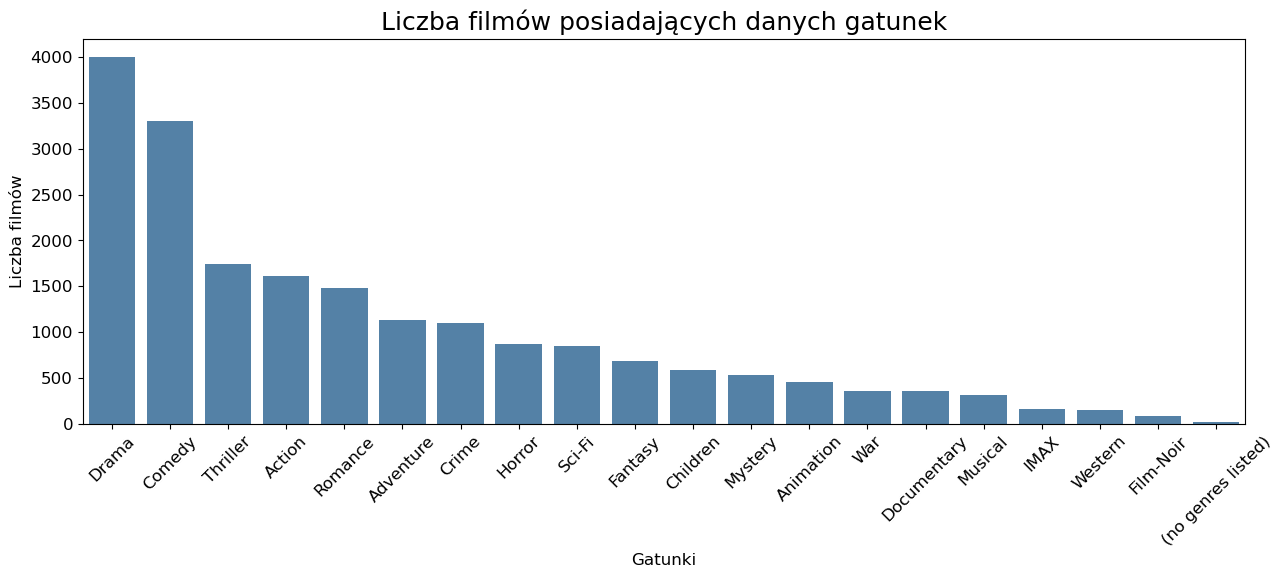

In [43]:
# Rozkład gatunków w filmach
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=genres_type_counts.index, y=genres_type_counts.values, color='steelblue')
ax.set_xlabel('Gatunki', fontsize = 12)
ax.set_ylabel('Liczba filmów', fontsize = 12)
ax.set_title('Liczba filmów posiadających danych gatunek', fontsize = 18)
plt.xticks(rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
#plt.tight_layout()
plt.show()

In [47]:
# Lista wszystkich możliwych ocen przed i po normalizacji
print(np.sort(ratings_df.old_rating.unique()))
print(np.round(np.sort(ratings_df.rating.unique()), decimals = 4))

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]
[0.     0.1111 0.2222 0.3333 0.4444 0.5556 0.6667 0.7778 0.8889 1.    ]


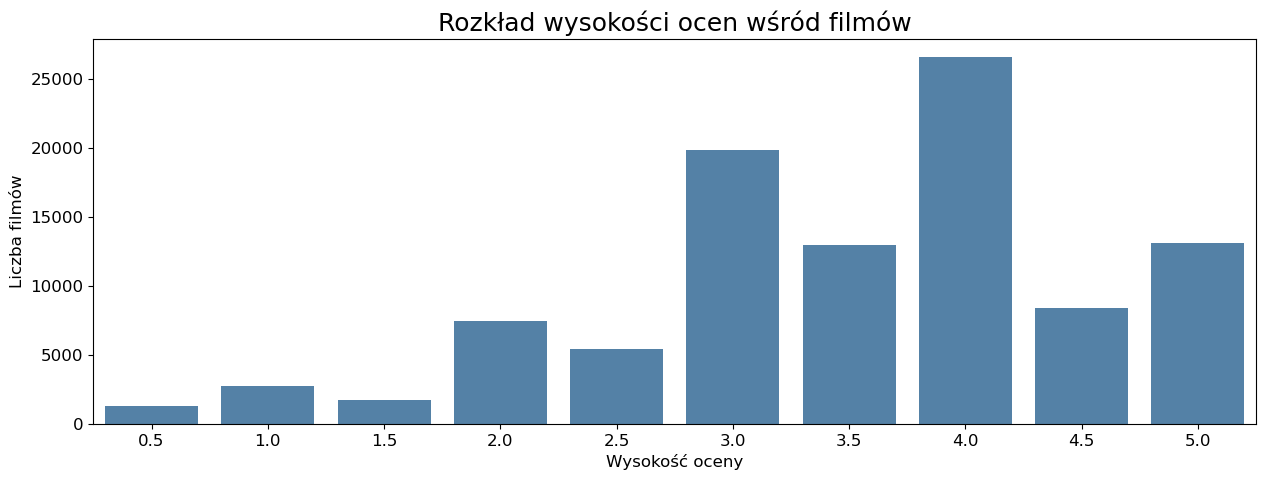

In [48]:
# Rozkład ocen
rating_type_counts = ratings_df.groupby("old_rating").count()["movie_id"]

fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x=rating_type_counts.index, y=rating_type_counts.values, color='steelblue')
ax.set_xlabel('Wysokość oceny', fontsize = 12)
ax.set_ylabel('Liczba filmów', fontsize = 12)
ax.set_title('Rozkład wysokości ocen wśród filmów', fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.tight_layout()
plt.show()

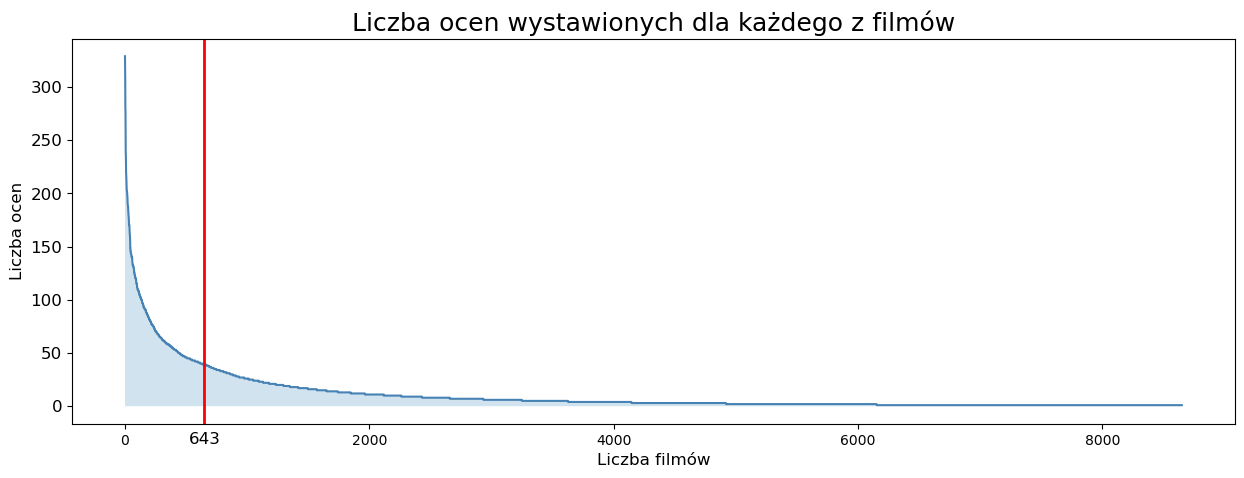

In [49]:
def find_x_at_halfarea(counts):
    """
    Znajduje takie x przy którym pole pod wykresem ocen podzielić można na pół.

    Parameters
    ----------
    rating_counts : TYPE pd.Series
        Seria z liczbą ocen dla każdego z użytkowników/filmów.

    Returns
    -------
    x_at_halfarea : TYPE int

    """
    rating_counts_integral_to_x = np.array([np.trapz(counts.values[:i], counts.index.values[:i]) for i in range(len(counts))])
    half_area = rating_counts_integral_to_x[-1] / 2
    
    x_at_halfarea = next(i for i, v in enumerate(rating_counts_integral_to_x) if v >= half_area)
    return x_at_halfarea

    
# Liczba ocen wystawionych dla każdego z filmów
movies_ratings_counts = ratings_df.groupby("movie_id").count()["rating"].sort_values(ascending=False).reset_index(drop=True) 
x_h_movies = find_x_at_halfarea(movies_ratings_counts)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=movies_ratings_counts.index, y=movies_ratings_counts.values, color='steelblue')
ax.set_xlabel('Liczba filmów', fontsize = 12)
ax.set_ylabel('Liczba ocen', fontsize = 12)
ax.set_title('Liczba ocen wystawionych dla każdego z filmów', fontsize = 18)
ax.fill_between(movies_ratings_counts.index, movies_ratings_counts.values, alpha=0.2)
plt.axvline(x=x_h_movies, color='red', linewidth=2)
plt.text(525, -35, str(x_h_movies), fontsize=12)
plt.yticks(fontsize = 12)
#plt.tight_layout()
plt.show()

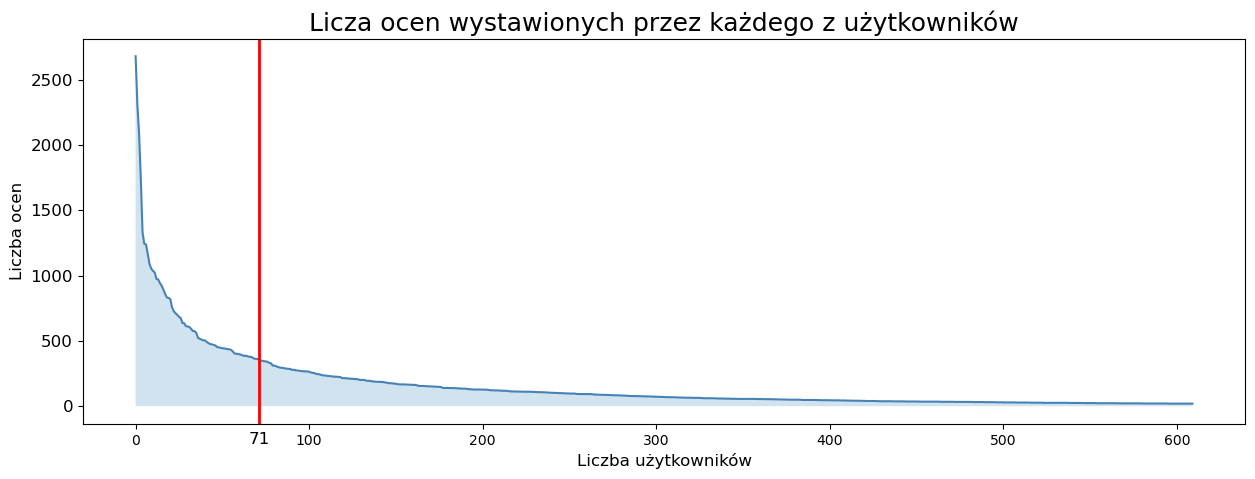

In [50]:
# Liczba ocen wystawionych przez każdego z użytkowników
users_ratings_counts = ratings_df.groupby("user_id").count()["rating"].sort_values(ascending=False).reset_index(drop=True)
x_h_users = find_x_at_halfarea(users_ratings_counts)

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=users_ratings_counts.index, y=users_ratings_counts.values, color='steelblue')
ax.set_xlabel('Liczba użytkowników', fontsize = 12)
ax.set_ylabel('Liczba ocen', fontsize = 12)
ax.set_title('Licza ocen wystawionych przez każdego z użytkowników', fontsize = 18)
ax.fill_between(users_ratings_counts.index, users_ratings_counts.values, alpha=0.2)
plt.axvline(x=x_h_users, color='red', linewidth=2)
plt.text(65, -291, str(x_h_users), fontsize=12)
plt.yticks(fontsize = 12)
#plt.tight_layout()
plt.show()

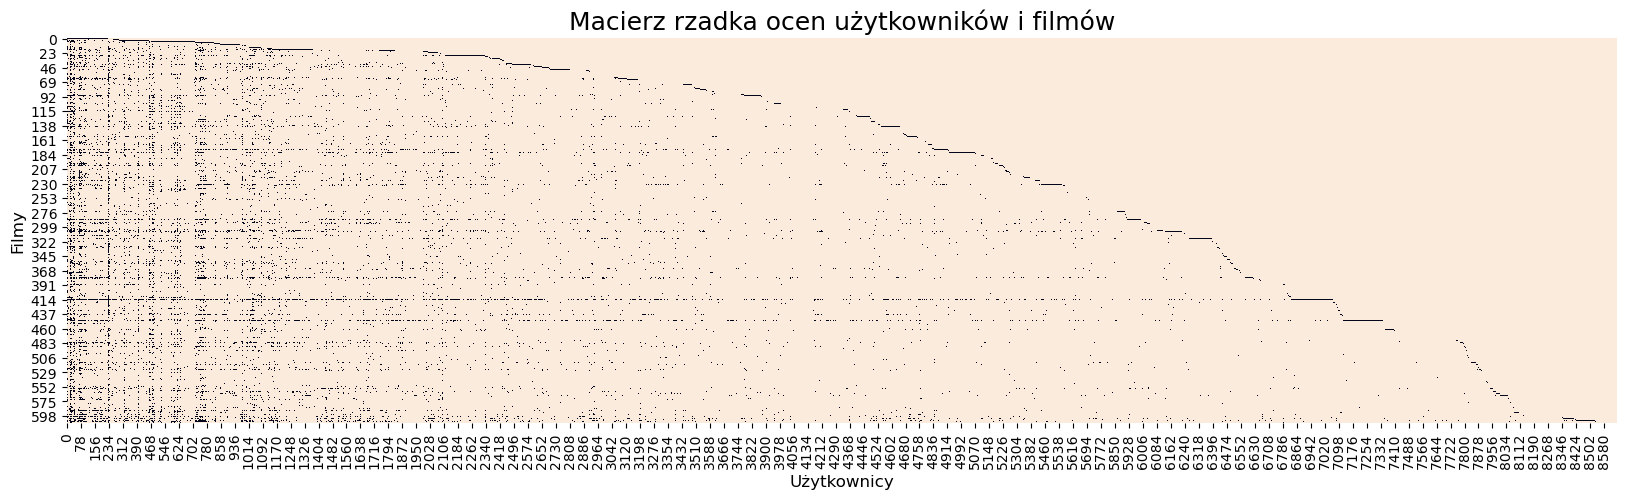

In [51]:
# Utworzenie macierzy rzadkiej ocen użytkowników i filmów
ratings_sparse_matrix = ratings_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=np.nan)

# Wykres macierzy rzadkiej
fig, ax = plt.subplots(figsize=(20,5))
sns.heatmap(ratings_sparse_matrix.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Macierz rzadka ocen użytkowników i filmów")
ax.set_xlabel('Użytkownicy', fontsize = 12)
ax.set_ylabel('Filmy', fontsize = 12)
ax.set_title('Macierz rzadka ocen użytkowników i filmów', fontsize = 18)
plt.show()

##############################################################################################
### Modele systemów rekomendacyjnych ###
##############################################################################################

In [52]:
# Podział zbioru ratings_df na uczący i testowy. Podział losowy.
train, test = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df['user_id'], random_state=1)
#print(len(test.user_id.unique()))

In [53]:
## Model losowy
def random_recommender(users_list, movies_list, k):
    '''
    Tworzy listę list K losowych filmów do zarekomendowania użytkownikowi.

    Parameters
    ----------
    users_list : lista  id użytkowników
    movies_list : lista  id flimóW
    k : liczba filmów do zarekomendowania

    Returns
    -------
    predicted_ratings_random_list : lista list K losowych rekomendacji dla wszystkich użytkowników

    '''
    
    predicted_ratings_list = [np.array(random.sample(list(movies_list), k)) for user in range(len(users_list))]
    
    return predicted_ratings_list

In [54]:
## Model popularnościowy
def popularity_recommender(users_list, movies_popularity_list:pd.Series, k):
    '''
    Tworzy listę list K najpopularniejszych filmów do zarekomendowania użytkownikowi.

    Parameters
    ----------
    users_list : lista  id użytkowników 
    movies_popularity_list: pd.Series  id flimóW z ilością ocen każdego z nich
    k : liczba filmów do zarekomendowania

    Returns
    -------
    predicted_ratings_random_list : lista list K najpopularniejszych rekomendacji dla wszystkich użytkowników

    '''
    topk = movies_popularity_list.iloc[:k].index.values
    predicted_ratings_list = [topk for user in users_list]
    
    return predicted_ratings_list

In [188]:
## Model SVD z biblioteki surprise
from surprise import accuracy, Dataset, SVD, Reader
from surprise.model_selection import train_test_split as surprise_train_test_split
svd_reader = Reader(rating_scale=(0.0, 1.0))

svd_data = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], svd_reader)

svd_trainset, svd_testset = surprise_train_test_split(svd_data, test_size=0.1)

svd_algo = SVD()

svd_algo.fit(svd_trainset)

svd_predictions = svd_algo.test(svd_testset)

#accuracy.mae(svd_predictions)

svd_test_df = pd.DataFrame(svd_testset, columns=['user_id', 'movie_id', 'rating'])

svd_unique_users = svd_test_df.user_id.unique()
svd_unique_movies =  svd_test_df.movie_id.unique()

def pred_user_svd(user_id, k):
    """
    Tworzy listę top K rekomendacji dla danego user_id według modelu SVD.
    
    Parameters
    ----------
    user_id : int
        id użytkownika.
    k : int 
        liczba filmów do rekomendacji.
    Returns
    -------
    top_movies : list
        list top K rekomendacji.
    
    """

    predictions = []
    for item in svd_unique_movies:
        prediction = svd_algo.predict(user_id, item)
        predictions.append(prediction)
      
    predictions.sort(key=lambda x: x.est, reverse=True)
      
    top_movies = [pred.iid for pred in predictions[:k]]
      
    return top_movies

In [84]:
## Model Content Based - Doc2Vec

# Wielkość wektorów doc2vec
doc2vec_vector_size = 20

In [ ]:

# Najczęstsze i zbędne wyrazy w języku angielskim
stop_words = stopwords.words('english')

def create_tokens(string_of_tags):
    """
    Funkcja czyszcząca listę tagów i tworząca z nich listę tokenów.

    Parameters
    ----------
    string_of_tags : TYPE string
        String z wszystkimi tagami odzielonymi przecinkami.
    Returns
    -------
    tokens : TYPE list
        Lista tokenów.
    """
    # Zamiana na małe litery
    string_of_tags.lower()
    # Podzielenie stringa na pojedyńcze wyrazy
    tokens = word_tokenize(string_of_tags)    
    # Usunięcie z listy tokenów wyrazów będacych jednym ze stop words oraz nie będących literowymi
    tokens = [token for token in tokens if not token in stop_words and token.isalpha()]
      
    return tokens

tags_tokens = [create_tokens(tags) for tags in movies_df["tags"]]

# Lista obiektów TaggedDocument zawierających tokeny dla każdego z filmów
tagged_docs = [TaggedDocument(words=item, tags=[str(index)]) for index,item in enumerate(tags_tokens)]


# Tworzenie modelu Doc2Vec.
# dm=0 -> wykorzystanie algorytmu distributed bag of words (PV-DBOW) 
doc2vec_model = Doc2Vec(vector_size=doc2vec_vector_size, alpha=0.025, min_alpha=0.00025, min_count=1, dm=0, workers=4)
doc2vec_model.build_vocab(tagged_docs)

# Uczenie modelu Doc2Vec
epoch_num = 50
print('Epoka: ')
for epoch in range(epoch_num):
  print(epoch)
  doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)
  doc2vec_model.alpha -= 0.0002
  doc2vec_model.min_alpha = doc2vec_model.alpha

In [61]:
# Zapisywanie modelu do pliku
#doc2vec_model.save('./models/doc2vecModel')

# Wczytywanie modelu z pliku
doc2vec_model = Doc2Vec.load('./models/doc2vecModel')

In [62]:
# Wektory reprezentujące filmy w 20 wymiarowej przestrzeni
doc2vec_movies_embbedings = doc2vec_model.dv.vectors
print(doc2vec_movies_embbedings.shape)

(8651, 20)


In [63]:
doc2vec_movies_embbedings

array([[ 1.247905  ,  0.7677842 , -1.1723193 , ..., -0.94149953,
         0.74298275,  0.00501734],
       [ 0.7493613 ,  1.3864921 ,  0.9614705 , ..., -1.336656  ,
        -1.8008074 ,  0.62193775],
       [ 0.64251685,  2.4487143 , -0.23545565, ..., -0.7543087 ,
         0.45784202,  1.7465965 ],
       ...,
       [ 0.13852872,  0.8593198 , -0.00909198, ..., -0.6752231 ,
        -0.88214874, -0.06569595],
       [-0.6683074 ,  0.7923568 ,  0.08183407, ..., -0.16789532,
        -1.0406001 , -0.5190705 ],
       [ 0.15620862,  0.2922575 , -0.00463694, ...,  0.5788121 ,
        -0.11069572,  0.41475868]], dtype=float32)

In [68]:
# Top20 filmów podobnych do filmu "Schindler's List"
example_movie = 28
sims = doc2vec_model.dv.most_similar(positive = [example_movie], topn = 10)
sims_df = pd.DataFrame(sims,columns=["movie_id", "cosine_similarity"])
sims_df.movie_id = sims_df.movie_id.astype('float64')
sims_df['title'] = sims_df['movie_id'].map(movies_df.set_index('movie_id')['title'])
sims_df['tags_list'] = sims_df['movie_id'].map(movies_df.set_index('movie_id')['tags_list'])

print("Top 10 filmów podobnych do filmu movie_id =", example_movie, "(",movies_df["title"][movies_df["movie_id"] == example_movie ].values[0], ")")


Top 10 filmów podobnych do filmu movie_id = 28 ( Schindler's List (1993) )


In [69]:
sims_df

,movie_id,cosine_similarity,title,tags_list
0,1197.0,0.879259,"Pianist, The (2002)","[holocaust, jews, poland, world war ii, nazis,..."
1,3083.0,0.820255,"Elephant Man, The (1980)","[lynch, compassionate, imdb top 250, biographi..."
2,794.0,0.816247,"Aviator, The (2004)","[biographical, biopic, aviation, oscar (best c..."
3,3440.0,0.804082,My Left Foot (1989),"[disability, biopic, oscar (best actor), cereb..."
4,884.0,0.802258,Hotel Rwanda (2004),"[genocide, africa, courage, civil war, true st..."
5,3080.0,0.796432,Sophie's Choice (1982),"[holocaust, oscar (best actress), heartbreakin..."
6,7878.0,0.795616,Nuremberg (2000),"[nazis, dramatic, holocaust, genocide, world w..."
7,748.0,0.791968,"Beautiful Mind, A (2001)","[oscar (best picture), schizophrenia, oscar (b..."
8,2199.0,0.788753,"Midnight Clear, A (1992)","[war, germany, best war films, world war ii, w..."
9,4409.0,0.786189,Birdy (1984),"[obsession, drama, friendship, unlikely friend..."


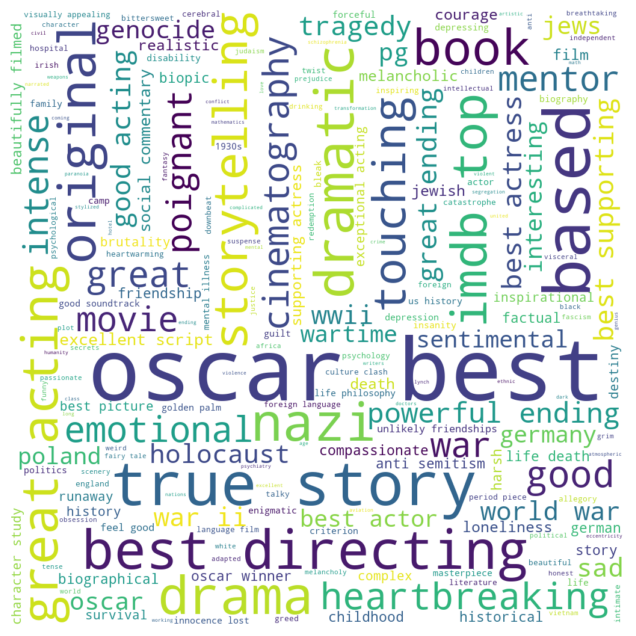

In [67]:
# Opisanie filmu za pomocą chmury słów (WordCloud) z tagów filmów podobnych
wordcloud_text = ' '.join([','.join(t) for t in sims_df.tags_list])
plt.rcParams["figure.figsize"] = (15,10)
# Wygenerowanie WordCloud
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(wordcloud_text)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [70]:
# Top 10 filmów podobnych do filmu "Lord of the Rings: Fellowship of the Ring"
example_movie = 747
sims = doc2vec_model.dv.most_similar(positive = [example_movie], topn = 10)
sims_df = pd.DataFrame(sims,columns=["movie_id", "cosine_similarity"])
sims_df.movie_id = sims_df.movie_id.astype('float64')
sims_df['title'] = sims_df['movie_id'].map(movies_df.set_index('movie_id')['title'])
sims_df['tags_list'] = sims_df['movie_id'].map(movies_df.set_index('movie_id')['tags_list'])

print("Top 10 filmów podobnych do filmu movie_id =", example_movie, "(",movies_df["title"][movies_df["movie_id"] == example_movie ].values[0], ")")


Top 20 filmów podobnych do filmu movie_id = 747 ( Lord of the Rings: The Fellowship of the Ring, The (2001) )


In [180]:
sims_df.head(10)

,movie_id,cosine_similarity,title,tags_list
0,768.0,0.981702,"Lord of the Rings: The Return of the King, The...","[high fantasy, trilogy, scenic, liv tyler, fan..."
1,758.0,0.972486,"Lord of the Rings: The Two Towers, The (2002)","[high fantasy, trilogy, scenic, liv tyler, myt..."
2,1327.0,0.939263,"Hobbit: An Unexpected Journey, The (2012)","[high fantasy, fantasy world, scenic, wizards,..."
3,952.0,0.914912,"Hobbit: The Desolation of Smaug, The (2013)","[high fantasy, fantasy world, based on a book,..."
4,172.0,0.861622,Superman (1978),"[super hero, superhero, superheroes, based on ..."
5,1903.0,0.842029,Harry Potter and the Deathly Hallows: Part 2 (...,"[emma watson, wizards, fantasy world, harry po..."
6,3031.0,0.834541,The Hobbit: The Battle of the Five Armies (2014),"[high fantasy, fantasy world, trilogy, wizards..."
7,454.0,0.833796,Harry Potter and the Sorcerer's Stone (a.k.a. ...,"[wizards, emma watson, fantasy world, magic, a..."
8,140.0,0.825701,"NeverEnding Story, The (1984)","[imagination, fantasy world, fantasy, based on..."
9,2460.0,0.821956,Harry Potter and the Order of the Phoenix (2007),"[wizards, emma watson, fantasy world, magic, a..."


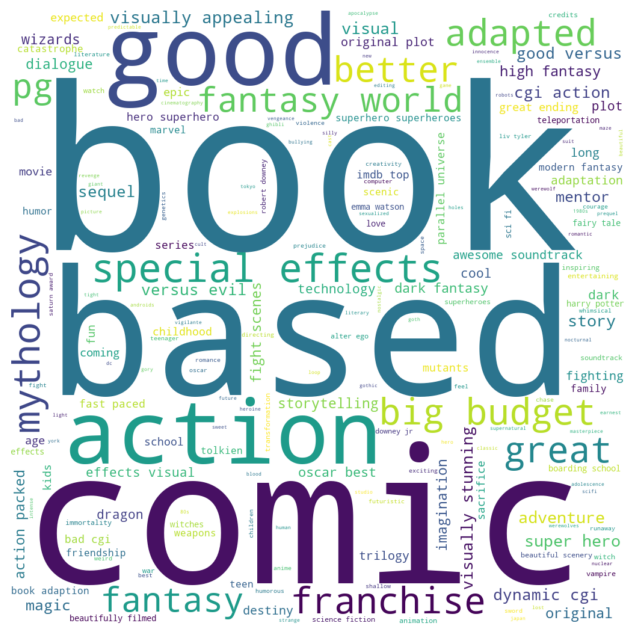

In [72]:
# Opisanie filmu za pomocą chmury słów (WordCloud) z tagów filmów podobnych
wordcloud_text = ' '.join([','.join(t) for t in sims_df.tags_list])
plt.rcParams["figure.figsize"] = (15,10)
# Wygenerowanie WordCloud
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(wordcloud_text)
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

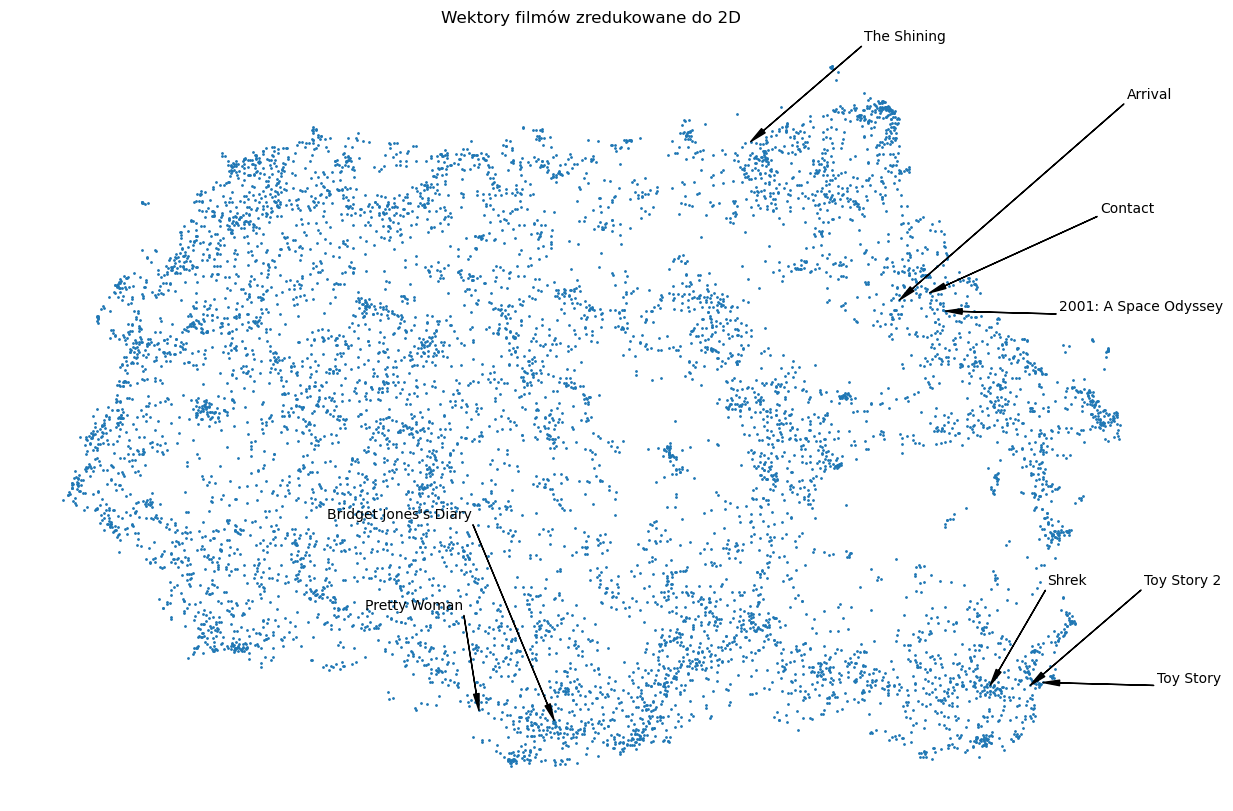

In [73]:
# Wizualizacja wektorów z pomocą narzędzia UMAP

# redukcja do 2 wymiarów
doc2vec_movies_embbedings_umap = umap.UMAP(n_components=2, n_neighbors = 10, min_dist = 0.005, metric = 'cosine').fit_transform(doc2vec_movies_embbedings)

x = doc2vec_movies_embbedings_umap[:,0]
y = doc2vec_movies_embbedings_umap[:,1]

fig, ax = plt.subplots(figsize=(15, 10))
plt.axis('off')
plt.title('Wektory filmów zredukowane do 2D')
plt.scatter(x, y, s=1)

# Wskazanie pozycji wybranych filmów
ax.annotate("Toy Story",
            xy=(x[0], y[0]),
            xytext=(x[0]+1, y[0]+0),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Toy Story 2",
            xy=(x[729], y[729]),
            xytext=(x[729]+1, y[729]+1),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Shrek",
            xy=(x[738], y[738]),
            xytext=(x[738]+0.5, y[738]+1),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("The Shining",
            xy=(x[7855], y[7855]),
            xytext=(x[7855]+1, y[7855]+1),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("2001: A Space Odyssey",
            xy=(x[717], y[717]),
            xytext=(x[717]+1, y[717]+0),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Contact",
            xy=(x[720], y[720]),
            xytext=(x[720]+1.5, y[720]+0.8),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Arrival",
            xy=(x[1367], y[1367]),
            xytext=(x[1367]+2, y[1367]+2),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Pretty Woman",
            xy=(x[477], y[477]),
            xytext=(x[477]-1, y[477]+1),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
ax.annotate("Bridget Jones's Diary",
            xy=(x[444], y[444]),
            xytext=(x[444]-2, y[444]+2),
            arrowprops=dict(facecolor='black', width=0.001, headwidth=4))
plt.show()

In [75]:
## Tworzenie profili użytkowników poprzez uśrednienie wektorów obejrzanych przez nich filmów

# Wybranie filmów ocenionych wyższej niż 3.0 ( 0.55... po normalizacji) ze zbioru TRENINGOWEGO, zakładając, 
# że oceny niższe oznaczają, że użytkownik nie jest zainteresowany danymi filmami

doc2vec_train_filtered = train[train["rating"] > 0.55]

def get_doc2vec_user_vector(user_id):
    """
    Zwraca wektor stanowiący profil użytkownika. Jeżeli user_id nie istnieje w doc2vec_train_filtered, 
    zwraca średnią wszystkich wektorów filmów
    """        
    user_movies = doc2vec_train_filtered["movie_id"][doc2vec_train_filtered["user_id"] == user_id]  
    if user_movies.empty:
        print("Doc2Vec - użytkownik: ",str(user_id)," nie istnieje w zbiorze. Wektor tego użytkownika == średnia wszystkich wektorów filmów")
        return np.mean(doc2vec_movies_embbedings, axis=0)
    
    user_vectors = doc2vec_movies_embbedings[user_movies, :]    
    user_vectors_mean = np.mean(user_vectors, axis=0) 
    
    return user_vectors_mean

    
def recommend_items_doc2vec(user_id, k, show_cos_sims=False):
    """
    Zwraca top K przedmiotów najbardziej podobnych wg. podobieństwa cosinusowego do wektora użytkownika.

    Parameters
    ----------
    user_id : int
        id użytkownika.
    k : int
        liczba filmów do zarekomendowania.
    show_cos_sims : boolean
        dodaj wartości podobieństwa cosinusowego filmów do wektora użytkownika       
    Returns
    -------
    predicted_ratings_list : list
        lista top K filmów.
    """
    user_vector = get_doc2vec_user_vector(user_id)
    
    predicted_ratings_list = doc2vec_model.dv.most_similar(positive = [user_vector], topn = k)
    
    array = np.array([[t[0], t[1]] for t in predicted_ratings_list]).astype('float64')
    
    if show_cos_sims:
       return array
        
    return array[:,0]

In [76]:
## Model Collaborative Filtering - Neural Collaborative Filtering

# Liczba użytkowników i filmów
users_len  = len(ratings_df.user_id.unique())
movies_len  = len(ratings_df.movie_id.unique())

# Wielkość wektorów cech ukrytych
movie_embedding = 50
user_embedding = 50

# Warstwy wejściowe #
input_movie = Input(shape=[1], name='input-movie')
input_user = Input(shape=[1], name='input-user')

# Warstwy faktoryzacji macierzy #
# Embeddingi faktoryzacji macierzy
mf_movie_embedding = Embedding(input_dim = movies_len + 1, output_dim = movie_embedding, name='mf_movie_embedding')(input_movie)
mf_user_embedding = Embedding(input_dim = users_len + 1, output_dim = user_embedding, name='mf_user_embedding')(input_user)
# Spłaszczenie embeddingów
mf_movie_flatten = Flatten(name='mf_movie_flatten')(mf_movie_embedding)
mf_user_flatten = Flatten(name='mf_user_flatten')(mf_user_embedding)
# Wyjście części modelu faktoryzującej macierz
mf_output = Dot(axes=1)([mf_movie_flatten, mf_user_flatten]) 

# Warstwy perceptronu wielowarstwoego #
# Embeddingi MLP
mlp_movie_embedding = Embedding(input_dim = movies_len + 1, output_dim = movie_embedding, name='mlp_movie_embedding')(input_movie)
mlp_user_embedding = Embedding(input_dim = users_len + 1, output_dim = user_embedding, name='mlp_user_embedding')(input_user)
# Spłaszczenie embeddingów
mlp_movie_flatten = Flatten(name='mlp_movie_flatten')(mlp_movie_embedding)
mlp_user_flatten = Flatten(name='mlp_user_flatten')(mlp_user_embedding)
# Konkatenacja spłaszczonych embeddingów
mlp_concatenate = Concatenate(axis=1)([mlp_movie_flatten, mlp_user_flatten]) 
mlp_concatenate_dropout = Dropout(0.2)(mlp_concatenate)

mlp_dense_1 = Dense(32, activation='relu', name='mlp_dense_1')(mlp_concatenate_dropout)
mlp_batch_norm_1 = BatchNormalization(name='mlp_batch_norm_1')(mlp_dense_1)
mlp_dropout_1 = Dropout(0.2)(mlp_batch_norm_1)
mlp_dense_2 = Dense(16, activation='relu', name='mlp_dense_2')(mlp_dropout_1)
mlp_batch_norm_2 = BatchNormalization(name='mlp_batch_norm_2')(mlp_dense_2)
mlp_dropout_2 = Dropout(0.2)(mlp_batch_norm_2)
# Wyjście części modelu MLP
mlp_output = Dense(8, activation='relu', name='mlp_output')(mlp_dropout_2)

# Konkatenacja wyjść obu części modelu
mf_mlp_concat = Concatenate(axis=1)([mf_output, mlp_output])

# Predykcja sieci
output = Dense(1, name='output', activation='relu')(mf_mlp_concat)

NeuCF_model = Model([input_user, input_movie], output)
NeuCF_model.compile(optimizer=Adam(), loss='mean_absolute_error')


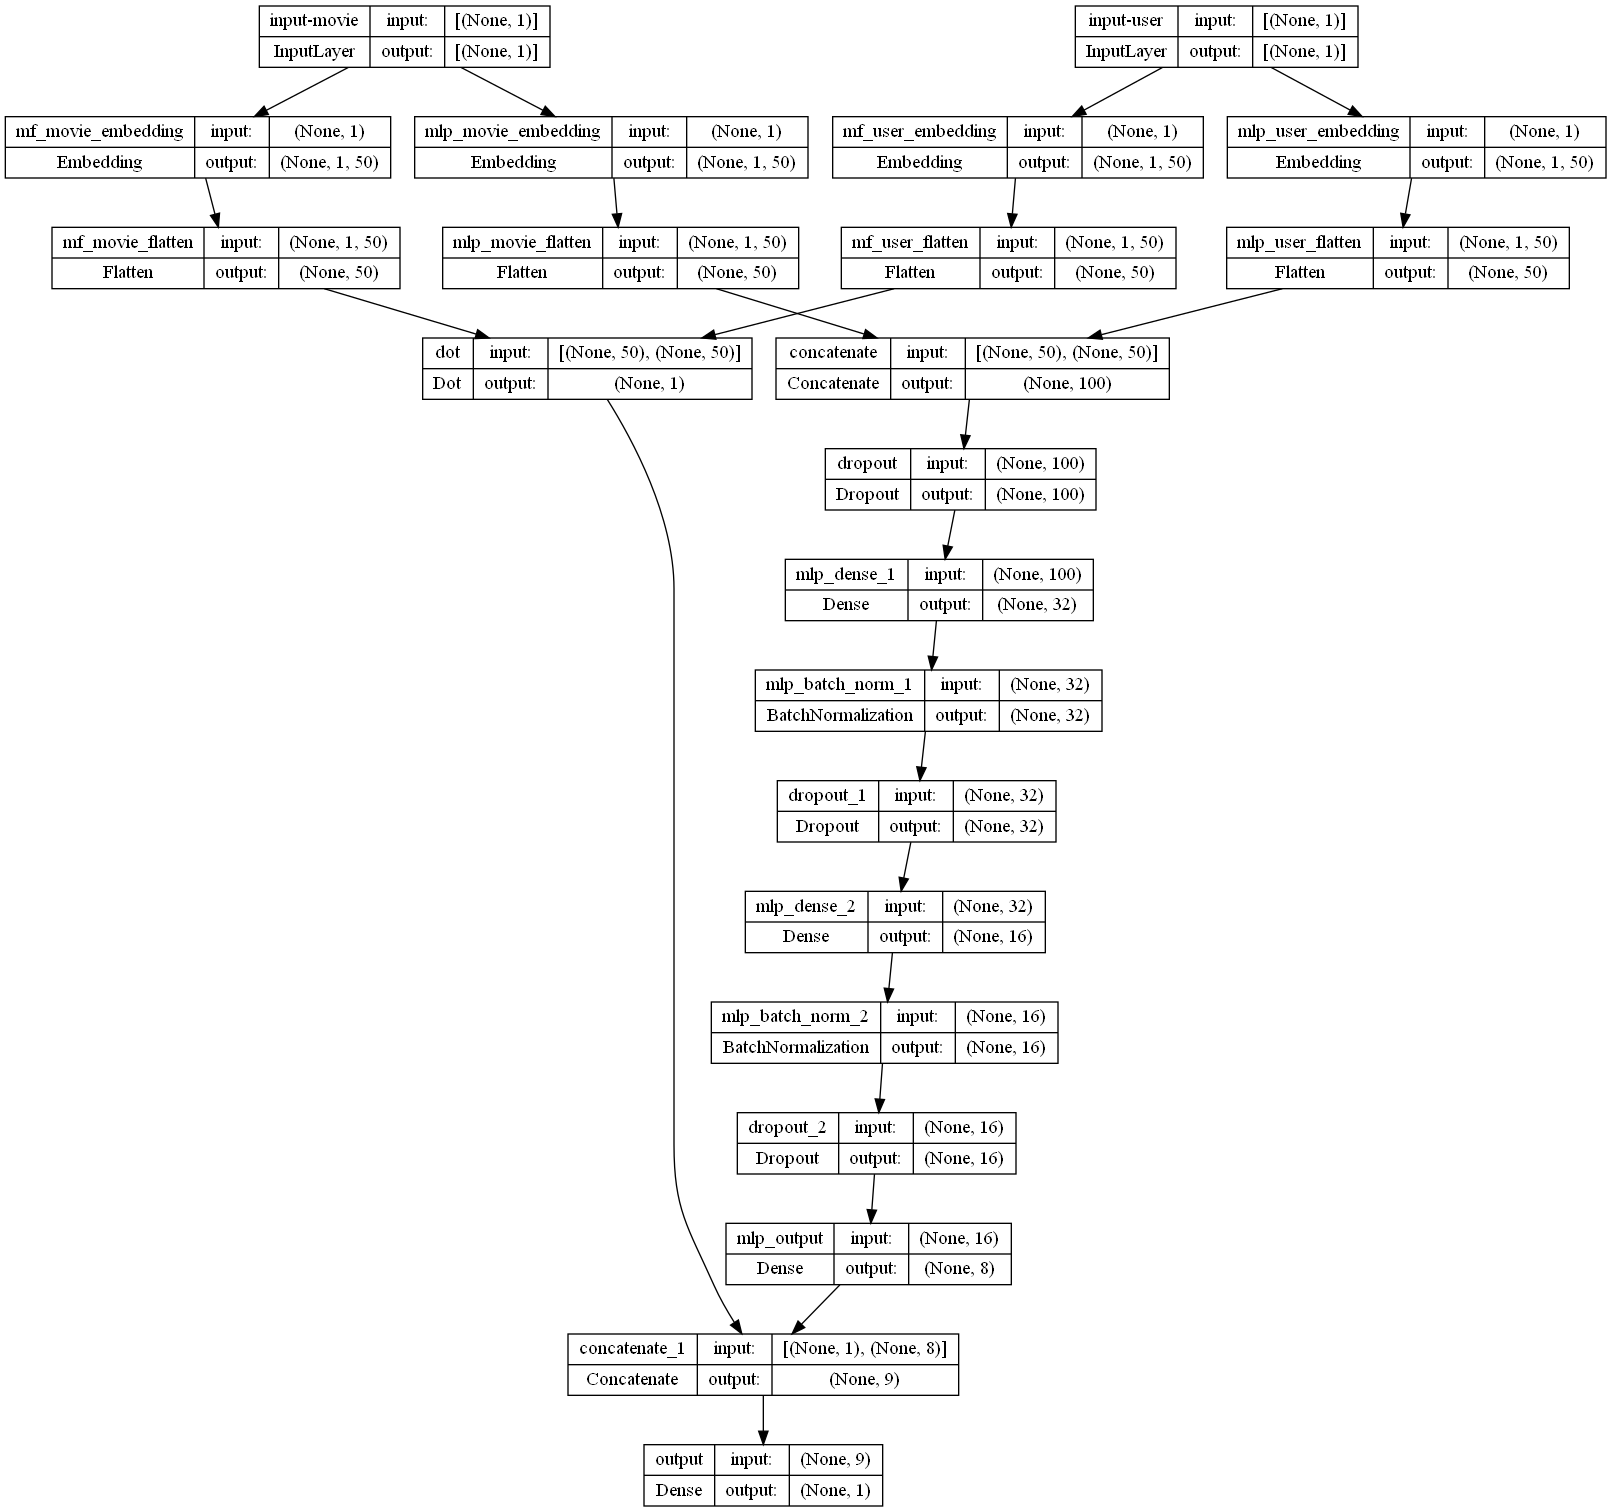

In [185]:
#SVG(model_to_dot(NeuCF_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))
#plot_model(NeuCF_model, to_file='neucf_model_visualization.svg', show_shapes=True, show_layer_names=True, dpi=65)
from keras.utils import plot_model
plot_model(NeuCF_model, show_shapes=True,to_file='model.png')

In [77]:
# Uczenie modelu NeuCF
history = NeuCF_model.fit([train.user_id, train.movie_id], train.rating, 
                          epochs=10, 
                          validation_data=[[test.user_id, test.movie_id], test.rating],
                          verbose = 0)

In [ ]:
## Zapisywanie modelu
# NeuCF_model.save('./models/NeuCF_model_50d_10e')
## Wczytywanie modelu
# NeuCF_model = keras.models.load_model('./models/NeuCF_model_50d_10e')

In [81]:
# Predykcje ocen dla wszystkich par użytkownik film w zbiorze testowym
y_hat = np.round(NeuCF_model.predict([test.user_id, test.movie_id]), decimals=4)
y_true = test.rating

print("MAE modelu NeuCF_model w zbiorze testowym: ", mean_absolute_error(y_true, y_hat))

622/622 [==============================] - 1s 2ms/step
MAE modelu NeuCF_model w zbiorze testowym:  0.16077113700446896


In [82]:
def recommend_items_neucf(user_id, k):
    """
    Zwraca top K przedmiotów najbardziej podobnych wg. wysokości predykowanych ocen dla użytkownika.

    Parameters
    ----------
    user_id : int
        id użytkownika.
    k : int
        liczba filmów do zarekomendowania.
    
    Returns
    -------
    predicted_ratings_list : list
        lista top K filmów.
    """
      
    all_movies = test['movie_id'].unique()  
    
    predictions = pd.DataFrame({'user_id': user_id, 'movie_id': all_movies})

    # Wygenerowanie predykcji dla każdej pary user_id i movie_id
    predictions['rating'] = np.round(NeuCF_model.predict([predictions['user_id'], predictions['movie_id']], verbose=False), decimals=4)
    
    predictions = predictions.sort_values(by="rating", ascending=False).head(k)
    
    return np.array(predictions["movie_id"]).astype('float64')

In [85]:
# Model hybrydowy - połączenie NeuCF i Doc2Vec

#Wektory doc2vec opisujące wszystkich użytkowników
doc2vec_users_embbedings = np.array([get_doc2vec_user_vector(user_id) for user_id in ratings_df.user_id.unique()])

# Liczba użytkowników i filmów
users_len  = len(ratings_df.user_id.unique())
movies_len  = len(ratings_df.movie_id.unique())

# Wielkość wektorów cech ukrytych
movie_embedding = 50
user_embedding = 50

# Warstwy wejściowe #
input_movie = Input(shape=[1], name='input-movie')
input_user = Input(shape=[1], name='input-user')

# Warstwy faktoryzacji macierzy #
# Embeddingi faktoryzacji macierzy
mf_movie_embedding = Embedding(input_dim = movies_len + 1, output_dim = movie_embedding, name='mf_movie_embedding')(input_movie)
mf_user_embedding = Embedding(input_dim = users_len + 1, output_dim = user_embedding, name='mf_user_embedding')(input_user)
# Spłaszczenie embeddingów
mf_movie_flatten = Flatten(name='mf_movie_flatten')(mf_movie_embedding)
mf_user_flatten = Flatten(name='mf_user_flatten')(mf_user_embedding)
# Wyjście części modelu faktoryzującej macierz
mf_output = Dot(axes=1)([mf_movie_flatten, mf_user_flatten]) 

# Warstwy perceptronu wielowarstwoego #
# Embeddingi MLP
mlp_movie_embedding = Embedding(input_dim = movies_len + 1, output_dim = movie_embedding, name='mlp_movie_embedding')(input_movie)
mlp_user_embedding = Embedding(input_dim = users_len + 1, output_dim = user_embedding, name='mlp_user_embedding')(input_user)
# Spłaszczenie embeddingów
mlp_movie_flatten = Flatten(name='mlp_movie_flatten')(mlp_movie_embedding)
mlp_user_flatten = Flatten(name='mlp_user_flatten')(mlp_user_embedding)
# Konkatenacja spłaszczonych embeddingów
mlp_concatenate = Concatenate(axis=1)([mlp_movie_flatten, mlp_user_flatten]) 
mlp_concatenate_dropout = Dropout(0.2)(mlp_concatenate)

mlp_dense_1 = Dense(32, activation='relu', name='mlp_dense_1')(mlp_concatenate_dropout)
mlp_batch_norm_1 = BatchNormalization(name='mlp_batch_norm_1')(mlp_dense_1)
mlp_dropout_1 = Dropout(0.2)(mlp_batch_norm_1)
mlp_dense_2 = Dense(16, activation='relu', name='mlp_dense_2')(mlp_dropout_1)
mlp_batch_norm_2 = BatchNormalization(name='mlp_batch_norm_2')(mlp_dense_2)
mlp_dropout_2 = Dropout(0.2)(mlp_batch_norm_2)
# Wyjście części modelu MLP
mlp_output = Dense(8, activation='relu', name='mlp_output')(mlp_dropout_2)

# Warstwy części content based Doc2Vec

doc2vec_movie_embedding = Embedding(input_dim = movies_len, output_dim = doc2vec_vector_size,
                                                       weights=[doc2vec_movies_embbedings], 
                                                       trainable=False, 
                                                       name='doc2vec_movie_embedding')(input_movie)
doc2vec_user_embedding = Embedding(input_dim = users_len, output_dim = doc2vec_vector_size,
                                                      weights=[doc2vec_users_embbedings], 
                                                      trainable=False,
                                                      name='doc2vec_user_embedding')(input_user)

doc2vec_movie_flatten = Flatten(name='doc2vec_movie_flatten')(doc2vec_movie_embedding)
doc2vec_user_flatten = Flatten(name='doc2vec_user_flatten')(doc2vec_user_embedding)

doc2vec_concatenate = Concatenate()([doc2vec_movie_flatten, doc2vec_user_flatten])
doc2vec_dense_1 = Dense(units=16, activation='relu', name='doc2vec_dense_1')(doc2vec_concatenate)
doc2vec_output = Dense(8, activation='relu', name='doc2vec_output')(doc2vec_dense_1)
# Konkatenacja wyjść części modelu
mf_mlp_doc2vec_concat = Concatenate(axis=1)([mf_output, mlp_output, doc2vec_output])

# Predykcja sieci
output = Dense(1, name='output', activation='relu')(mf_mlp_doc2vec_concat)

Hybrid_model = Model([input_user, input_movie], output)
Hybrid_model.compile(optimizer=Adam(), loss='mean_absolute_error')

Doc2Vec - użytkownik:  441  nie istnieje w zbiorze. Wektor tego użytkownika == średnia wszystkich wektorów filmów


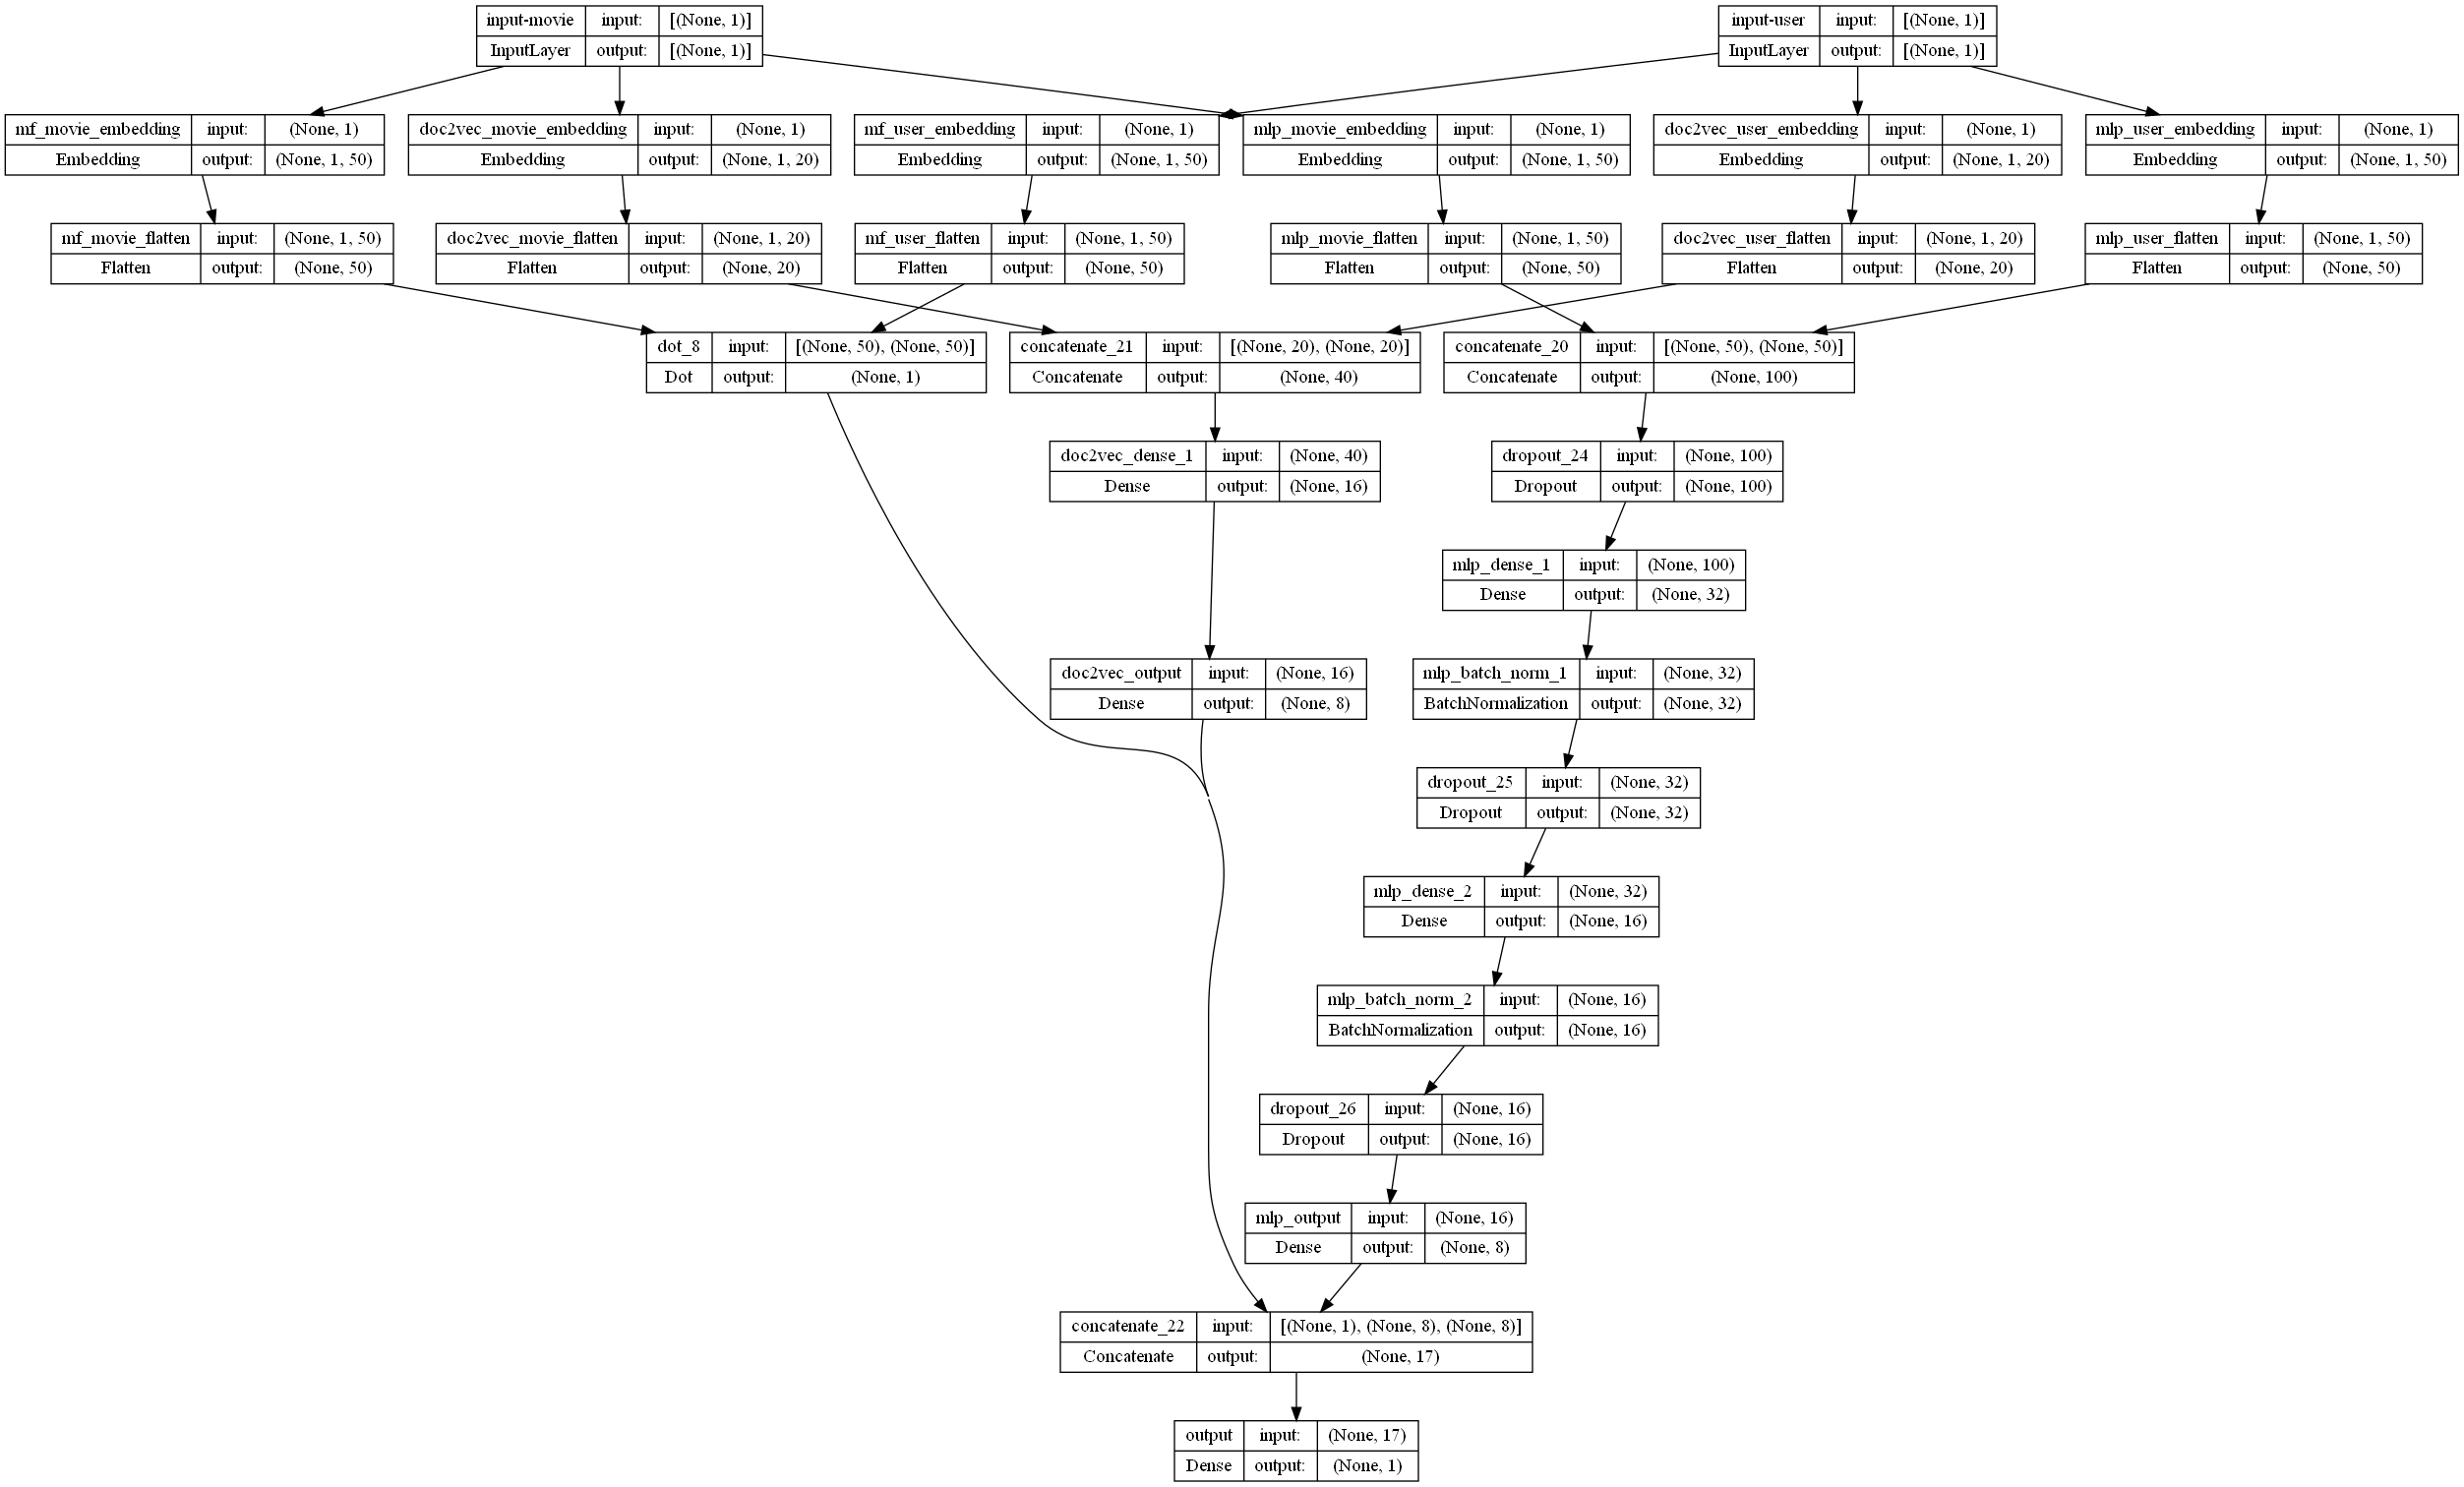

In [187]:
#SVG(model_to_dot(Hybrid_model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))
from keras.utils import plot_model
plot_model(Hybrid_model, show_shapes=True,to_file='hybrid_model.png')

In [90]:
# Uczenie modelu hybrydowego
history_hybrid = Hybrid_model.fit([train.user_id, train.movie_id], train.rating, 
                                  epochs=10, 
                                  validation_data=[[test.user_id, test.movie_id], test.rating],
                                  verbose = 0)

In [92]:
# Zapisywanie modelu
#Hybrid_model.save('./models/Hybrid_model_50d_10e')
# Wczytywanie modelu
Hybrid_model = keras.models.load_model('./models/Hybrid_model_50d_10e')

In [93]:
# Predykcje ocen dla wszystkich par użytkownik film w zbiorze testowym
y_hat = np.round(Hybrid_model.predict([test.user_id, test.movie_id]), decimals=4)
y_true = test.rating

print("MAE modelu Hybrid_model w zbiorze testowym: ", mean_absolute_error(y_true, y_hat))

622/622 [==============================] - 2s 2ms/step
MAE modelu Hybrid_model w zbiorze testowym:  0.1592130771255982


In [94]:
def recommend_items_hybrid(user_id, k):
    """
    Zwraca top K przedmiotów najbardziej podobnych wg. wysokości predykowanych ocen dla użytkownika.

    Parameters
    ----------
    user_id : int
        id użytkownika.
    k : int
        liczba filmów do zarekomendowania.
    
    Returns
    -------
    predicted_ratings_list : list
        lista top K filmów.
    """
      
    all_movies = test['movie_id'].unique()  
    
    predictions = pd.DataFrame({'user_id': user_id, 'movie_id': all_movies})

    # Wygenerowanie predykcji dla każdej pary user_id i movie_id
    predictions['rating'] = np.round(Hybrid_model.predict([predictions['user_id'], predictions['movie_id']], verbose=False), decimals=4)
    
    predictions = predictions.sort_values(by="rating", ascending=False).head(k)
    
    return np.array(predictions["movie_id"]).astype('float64')

##############################################################################################
### Ewaluacja modeli ###
##############################################################################################

In [102]:
# Sprawdzanie rekomendacji dla przykładowego użytkownika
def check_user_recs(user_id,users_predicted_ratings_list):
    """
    Wyświetla listę topk filmów rzeczywiście ocenionych przez podanego użytkownika 
    oraz listę topk filmów zarekomendowanych dla użytkownika przez dany model.

    Parameters
    ----------
    user_id : int
        id użytkownika.
    users_predicted_ratings_list : list
        lista list topk rekomendacji utworzyonych prez jeden z modelu rekomendacji.

    Returns
    -------
    None.

    """
    
    #pd.set_option('display.max_columns', 6)
    #print("Obejrzane filmy: ")
    example_true_ratings_list = top_ratings_real[user_id]
    example_true_ratings_list_df = movies_df[movies_df['movie_id'].isin(example_true_ratings_list)]
    #print(example_true_ratings_list_df.loc[:, ['title', 'genres']].to_string(index=False))
    
    #print("Rekomendowane filmy: ")
    example_predicted_ratings_list = users_predicted_ratings_list[user_id]
    example_predicted_ratings_list_df = movies_df[movies_df['movie_id'].isin(example_predicted_ratings_list)]
    #print(example_predicted_ratings_list_df.loc[:, ['title', 'genres']].to_string(index=False))
    return example_true_ratings_list_df.loc[:, ['title', 'genres']], example_predicted_ratings_list_df.loc[:, ['title', 'genres']]

In [97]:
# Tabela wyników ewaluacji
evaluation_df = pd.DataFrame(columns=["MTP", "MRR", "MAP", "MAR", "Personalization", "Intra-list Similarity", "Coverage", ])
    
def evaluate_model(model_name, list_of_topk_lists_true, list_of_topk_lists_pred, k, catalog_dataset=test):
    '''
    Funkcja obliczająca dla danego modelu wszystkie zastosowane metryki i dodające ich wyniki do evaluation_df.
    
    Parameters
    ----------
    model_name : nazwa modelu
    list_of_topk_lists_true : lista list najwyzej ocenionych filmów przez użytkowników
    list_of_topk_lists_pred : lista list top k rekomendowanych filmów
    k : liczba rekomendacji
    catalog_dataset : dataset z którego wybrane zostaną movie_id.unique()

    Returns
    -------
    evaluation_list : wyniki metryk dla danego modelu

    '''
    real_list = [list(x) for x in list_of_topk_lists_true]
    pred_list = [list(x) for x in list_of_topk_lists_pred]
    catalog = list(catalog_dataset.movie_id.unique())
    
    evaluation_list = [r_metrics.mean_true_positives_percentage(list_of_topk_lists_true, list_of_topk_lists_pred),
                       r_metrics.mean_reciprocal_rank(list_of_topk_lists_true, list_of_topk_lists_pred),
                       r_metrics.mean_average_precision(list_of_topk_lists_true,list_of_topk_lists_pred),
                       #recmetrics.mark(real_list, pred_list,  k),
                       r_metrics.mean_average_recall(list_of_topk_lists_true,list_of_topk_lists_pred),
                       recmetrics.personalization(pred_list),
                       recmetrics.intra_list_similarity(pred_list, pd.DataFrame(doc2vec_movies_embbedings)),
                       recmetrics.prediction_coverage(pred_list, catalog)] 
    
    evaluation_df.loc[model_name] = evaluation_list

In [98]:
k = 20

################## Prawdziwe oceny ##################
# Lista z listami najlepszych filmów dla każdego użytkownika (wg. ocen)
top_ratings_real = test.groupby('user_id').apply(
    lambda x: np.array(x.sort_values('rating', ascending=False)['movie_id'].head(k)).astype('float64')).tolist()

In [126]:
###### Rekomendacja losowa
random_topk_recommendations = random_recommender(np.sort(test.user_id.unique()), np.sort(test.movie_id.unique()), k)

# Oblczenie metryk dla modelu
evaluate_model("Random", top_ratings_real, random_topk_recommendations, k)

In [224]:
user_id = 17

In [225]:
# Sprawdzenie rekomendacji dla wybranych użytkowników
watched, recommended = check_user_recs(user_id,random_topk_recommendations)

In [226]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [227]:
recommended.head(10)

,title,genres
274,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
436,Thirteen Days (2000),Drama|Thriller|War
781,Sky Captain and the World of Tomorrow (2004),Action|Adventure|Sci-Fi
1405,Kazaam (1996),Children|Comedy|Fantasy
1531,"Purple Rose of Cairo, The (1985)",Comedy|Drama|Fantasy|Romance
2397,Ponette (1996),Drama
2419,Ringu (Ring) (1998),Horror|Mystery|Thriller
2683,Room (2015),Drama
2992,"Fountain, The (2006)",Drama|Fantasy|Romance
3262,Wimbledon (2004),Comedy|Romance


In [228]:
################## Rekomendacja popularnościowa ##################
popularity_topk_recommendations = popularity_recommender(np.sort(test.user_id.unique()), test.movie_id.value_counts(), k)
# Oblczenie metryk dla modelu
evaluate_model("Popularity", top_ratings_real, popularity_topk_recommendations, k)

In [229]:
#Sprawdzenie rekomendacji dla wybranych użytkowników
watched, recommended = check_user_recs(user_id,popularity_topk_recommendations)

In [230]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [231]:
recommended.head(10)

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
15,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
16,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
20,Forrest Gump (1994),Comedy|Drama|Romance|War
25,"Fugitive, The (1993)",Thriller
26,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
33,Batman (1989),Action|Crime|Thriller
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
36,Fargo (1996),Comedy|Crime|Drama|Thriller


In [232]:
################## Rekomendacja SVD ##################
svd_topk_recommendations = [np.array(pred_user_svd(user_id, k)) for user_id in svd_unique_users]

# Lista z listami najlepszych filmów dla każdego użytkownika (wg. ocen) dla SVD
svd_top_ratings_real = svd_test_df.groupby('user_id').apply(
    lambda x: np.array(x.sort_values('rating', ascending=False)['movie_id'].head(k)).astype('float64')).tolist()

# Oblczenie metryk dla modelu
evaluate_model("SVD", svd_top_ratings_real, svd_topk_recommendations, k, catalog_dataset = svd_test_df)

In [233]:
watched, recommended = check_user_recs(user_id,svd_topk_recommendations)

In [234]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [235]:
recommended.head(10)

,title,genres
2,Heat (1995),Action|Crime|Thriller
72,Apocalypse Now (1979),Action|Drama|War
73,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
232,"Shawshank Redemption, The (1994)",Crime|Drama
243,Exit Through the Gift Shop (2010),Comedy|Documentary
351,Amadeus (1984),Drama
421,"Outlaw Josey Wales, The (1976)",Action|Adventure|Drama|Thriller|Western
858,"Graduate, The (1967)",Comedy|Drama|Romance
1206,Monty Python's The Meaning of Life (1983),Comedy
1237,Kiss Kiss Bang Bang (2005),Comedy|Crime|Mystery|Thriller


In [236]:
# Lista z listami najlepszych filmów dla każdego użytkownika (wg. ocen) dla modelu Doc2Vec
doc2vec_top_ratings_real = test[test['user_id'].isin(doc2vec_train_filtered['user_id'])].groupby('user_id').apply(
    lambda x: np.array(x.sort_values('rating', ascending=False)['movie_id'].head(k)).astype('float64')).tolist()

doc2vec_topk_recommendations = [recommend_items_doc2vec(user_id, k) for user_id in doc2vec_train_filtered.user_id.unique()]

# Oblczenie metryk dla modelu
evaluate_model("CB - Doc2Vec", doc2vec_top_ratings_real, doc2vec_topk_recommendations, k, catalog_dataset = ratings_df)

In [237]:
watched, recommended = check_user_recs(user_id,doc2vec_topk_recommendations)

In [238]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [239]:
recommended.head(10)

,title,genres
45,Citizen Kane (1941),Drama|Mystery
277,Requiem for a Dream (2000),Drama
391,"Nights of Cabiria (Notti di Cabiria, Le) (1957)",Drama
412,Magnolia (1999),Drama
2044,"Killing, The (1956)",Crime|Film-Noir
2444,Drugstore Cowboy (1989),Crime|Drama
2871,Husbands and Wives (1992),Comedy|Drama
3097,Talk to Her (Hable con Ella) (2002),Drama|Romance
3401,"Hustler, The (1961)",Drama
3444,Bicycle Thieves (a.k.a. The Bicycle Thief) (a....,Drama


In [240]:
################## Rekomendacja collaborative filtering NeuCF ##################
# Długie działanie! 
neucf_topk_recommendations = [recommend_items_neucf(user_id, k) for user_id in test.user_id.unique()]

# Oblczenie metryk dla modelu
evaluate_model("CF - NeuCF", top_ratings_real, neucf_topk_recommendations, k)

In [241]:
watched, recommended = check_user_recs(user_id,neucf_topk_recommendations)

In [242]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [243]:
recommended.head(10)

,title,genres
4,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
16,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
28,Schindler's List (1993),Drama|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
177,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi
179,"South Park: Bigger, Longer and Uncut (1999)",Animation|Comedy|Musical
192,Fight Club (1999),Action|Crime|Drama|Thriller
197,Being John Malkovich (1999),Comedy|Drama|Fantasy
231,M*A*S*H (a.k.a. MASH) (1970),Comedy|Drama|War
262,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy


In [244]:
################## Rekomendacja hybrydowa NeuCF Doc2Vec + NeuCF ##################
hybrid_topk_recommendations = [recommend_items_hybrid(user_id, k) for user_id in ratings_df.user_id.unique()]

# Oblczenie metryk dla modelu
evaluate_model("Hybrid model", top_ratings_real, hybrid_topk_recommendations, k)

In [245]:
watched, recommended = check_user_recs(user_id,hybrid_topk_recommendations)

In [246]:
watched.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
34,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
67,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
76,Psycho (1960),Crime|Horror
251,Django Unchained (2012),Action|Drama|Western
253,Interstellar (2014),Sci-Fi|IMAX
399,"Sixth Sense, The (1999)",Drama|Horror|Mystery
584,Léon: The Professional (a.k.a. The Professiona...,Action|Crime|Drama|Thriller
748,"Beautiful Mind, A (2001)",Drama|Romance
1014,Snatch (2000),Comedy|Crime|Thriller


In [247]:
recommended.head(10)

,title,genres
20,Forrest Gump (1994),Comedy|Drama|Romance|War
45,Citizen Kane (1941),Drama|Mystery
102,Conan the Barbarian (1982),Action|Adventure|Fantasy
200,Dogma (1999),Adventure|Comedy|Fantasy
232,"Shawshank Redemption, The (1994)",Crime|Drama
330,Rear Window (1954),Mystery|Thriller
349,12 Angry Men (1957),Drama
1095,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western
1127,Once Upon a Time in the West (C'era una volta ...,Action|Drama|Western
1128,"Godfather: Part II, The (1974)",Crime|Drama


In [254]:
evaluation_df = evaluation_df.round(5)
evaluation_df

,MTP,MRR,MAP,MAR,Personalization,Intra-list Similarity,Coverage
Random,0.00221,0.00570,0.00042,0.00342,0.99585,0.23477,91.75
Popularity,0.06303,0.21896,0.03137,0.10315,-0.00000,0.41731,0.41
SVD,0.00756,0.02846,0.00329,0.01799,0.93351,0.33104,39.55
CB - Doc2Vec,0.01092,0.03871,0.00337,0.01627,0.94127,0.65032,21.34
CF - NeuCF,0.01328,0.04249,0.00367,0.01833,0.97239,0.31904,40.33
Hybrid model,0.01623,0.05387,0.00386,0.02245,0.96672,0.33578,32.78


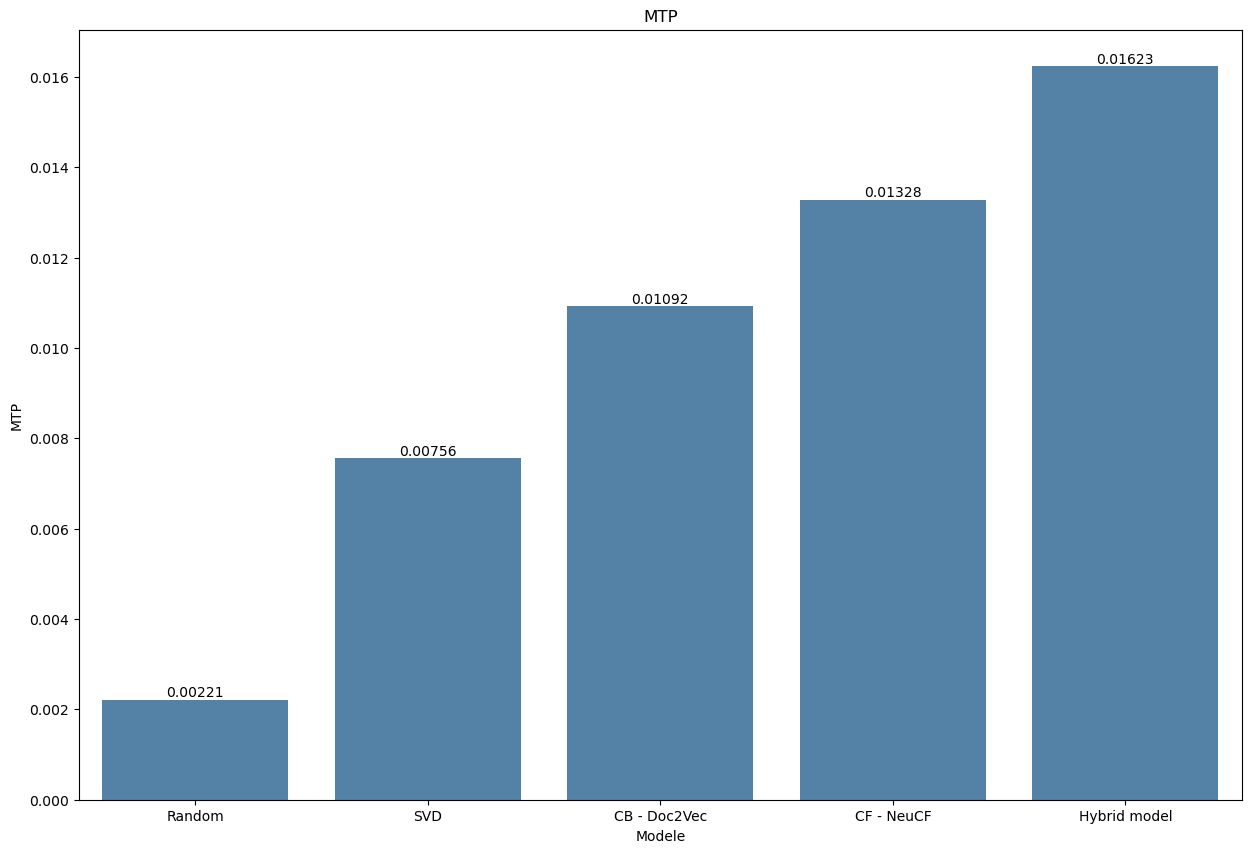

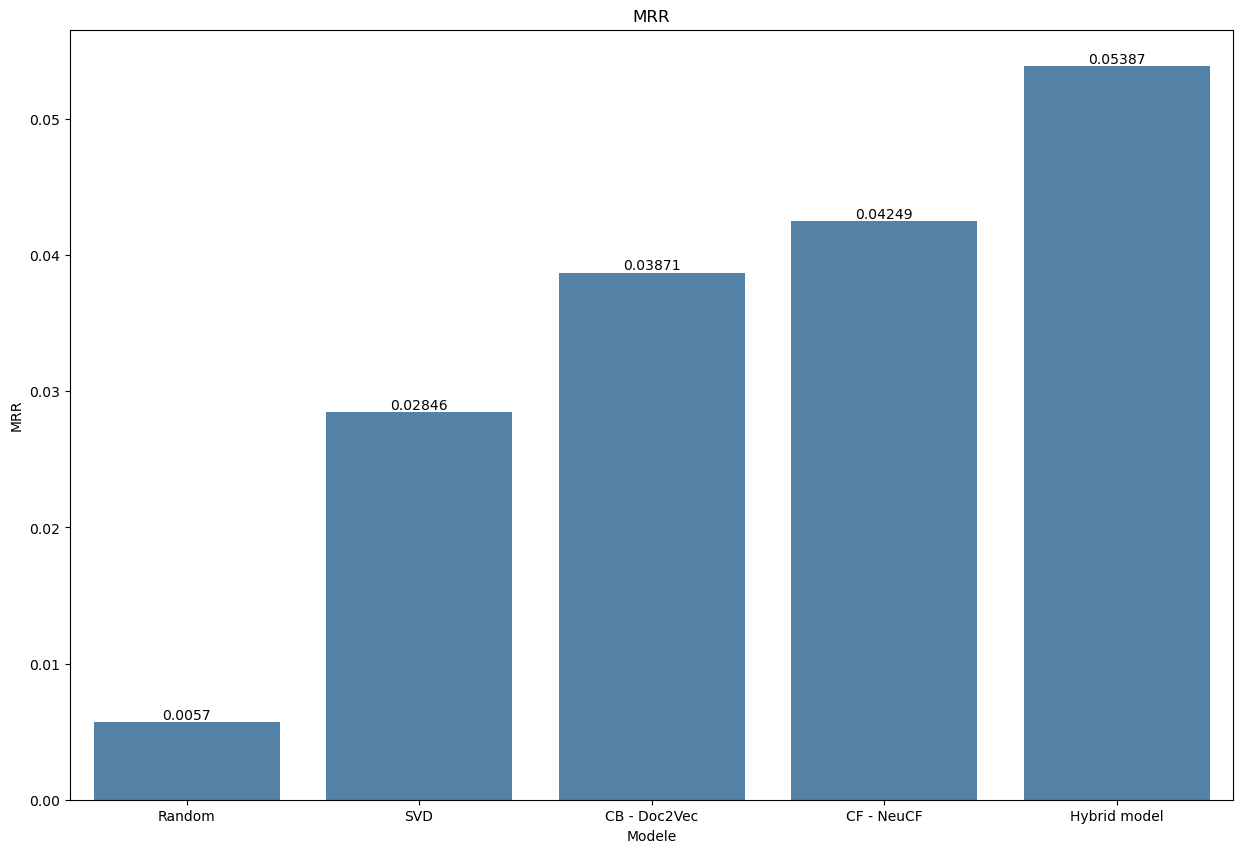

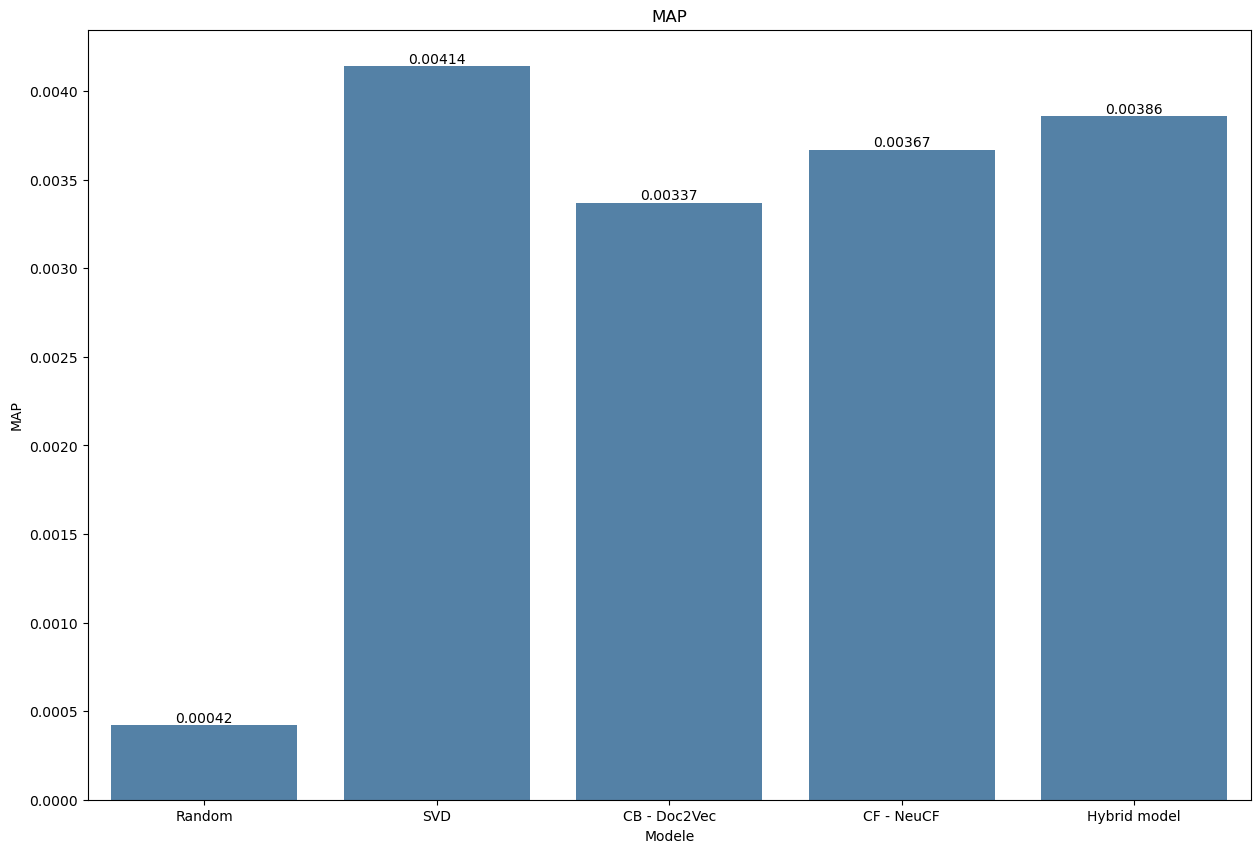

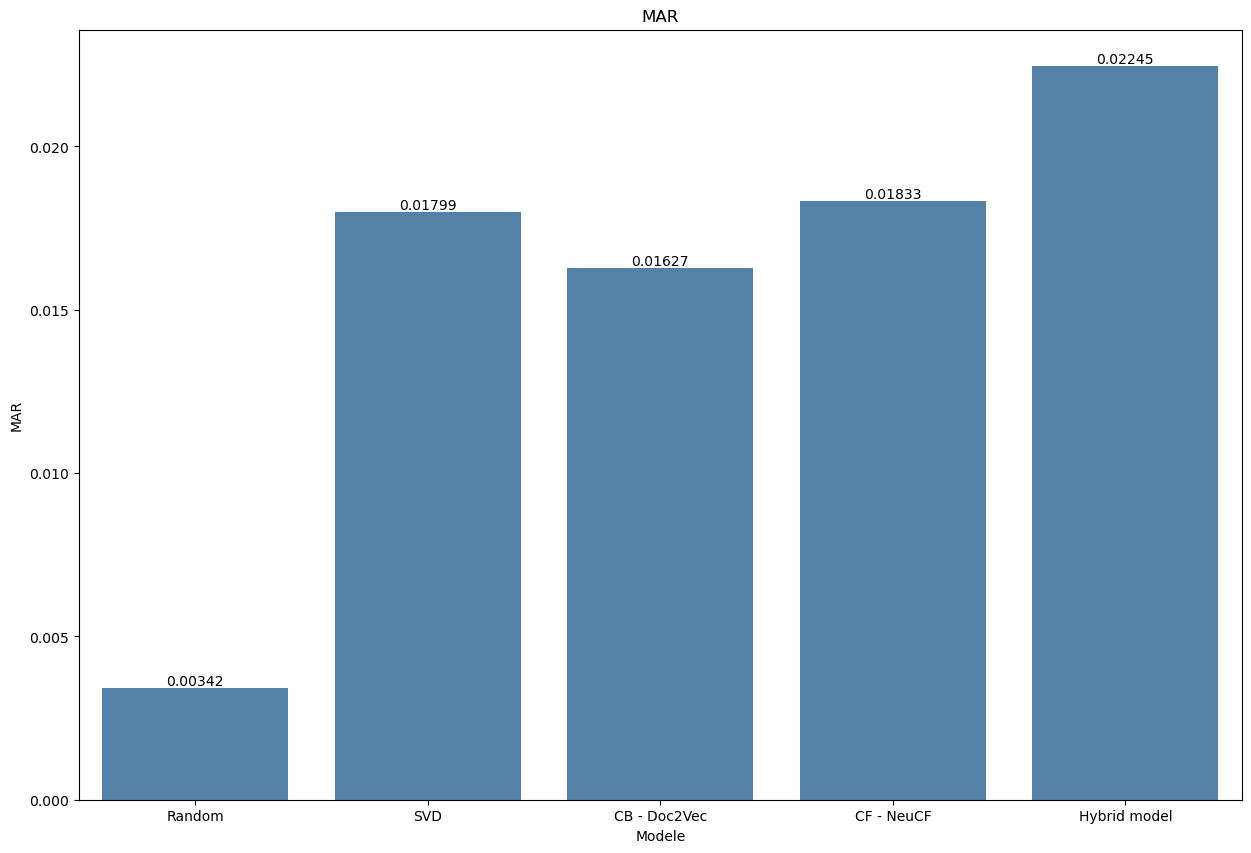

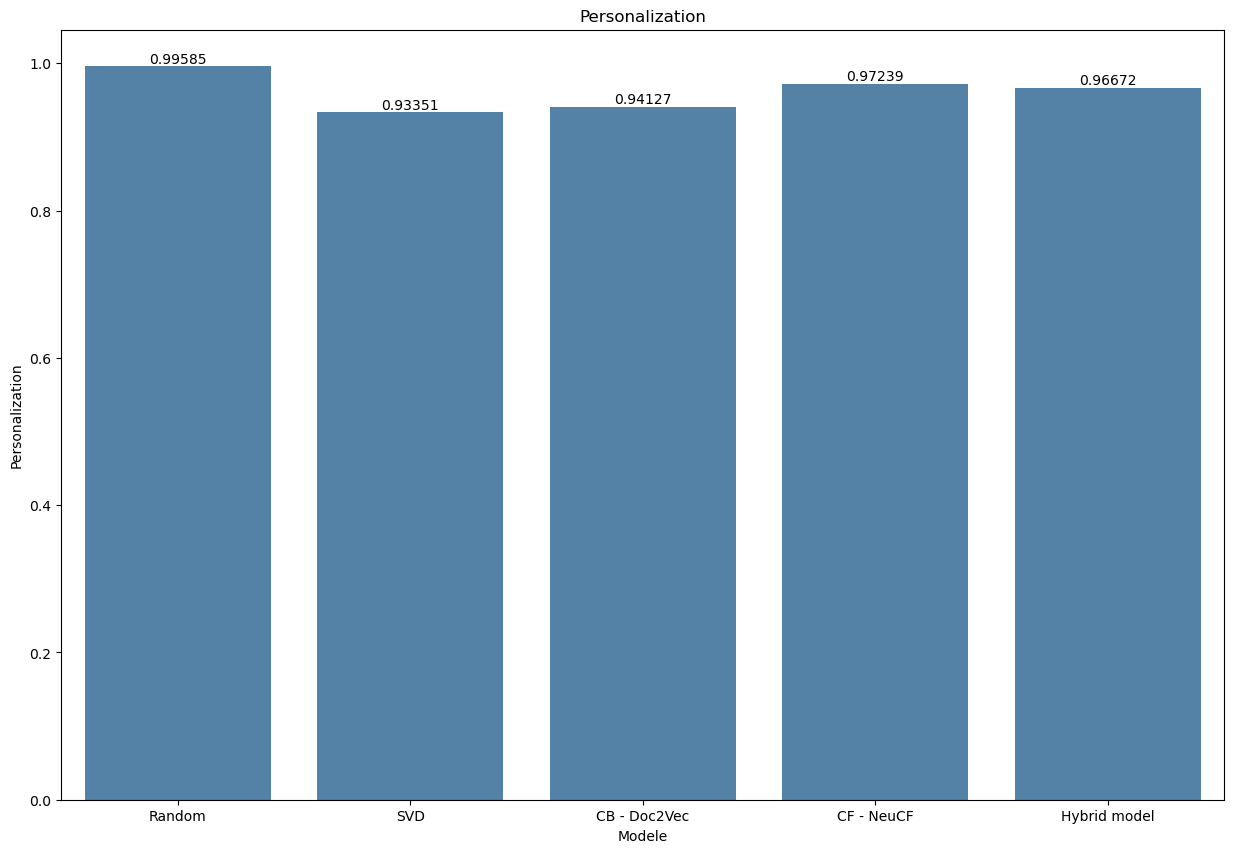

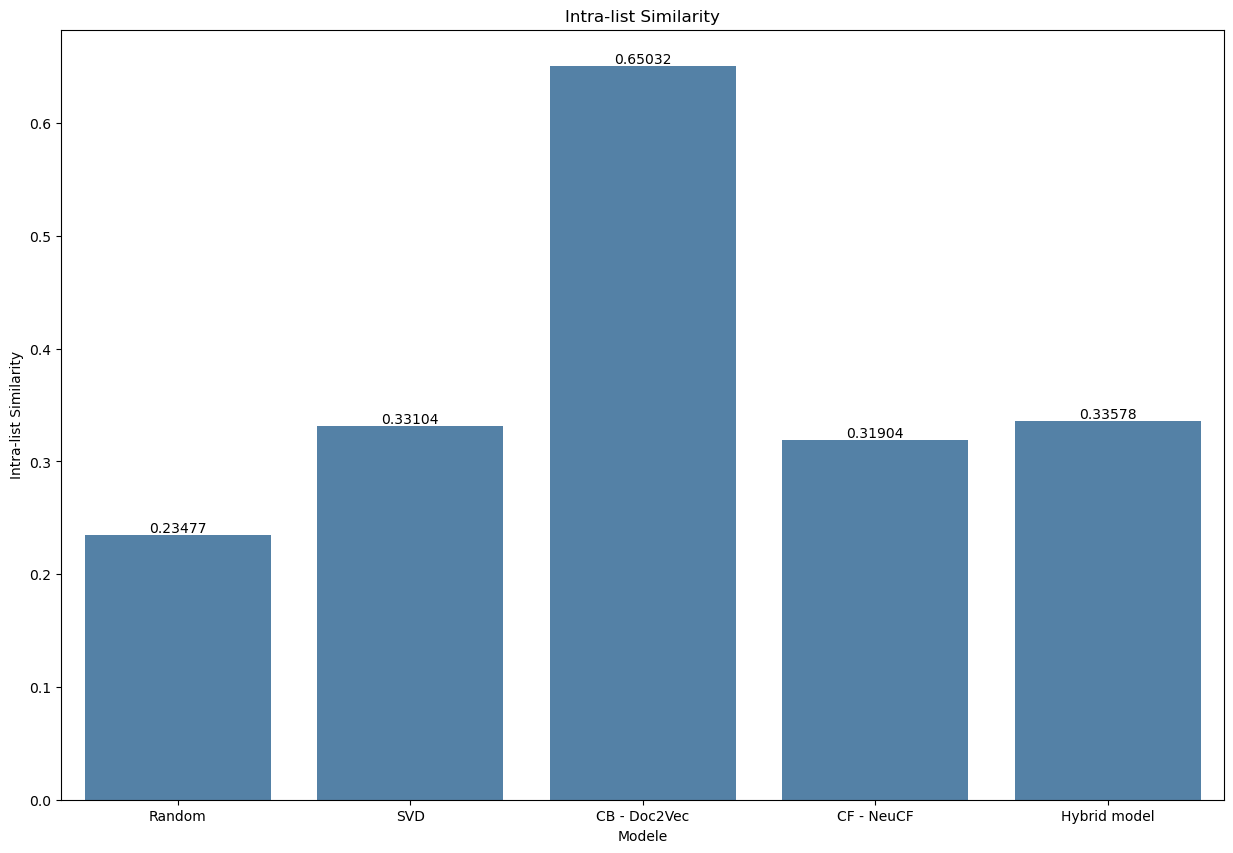

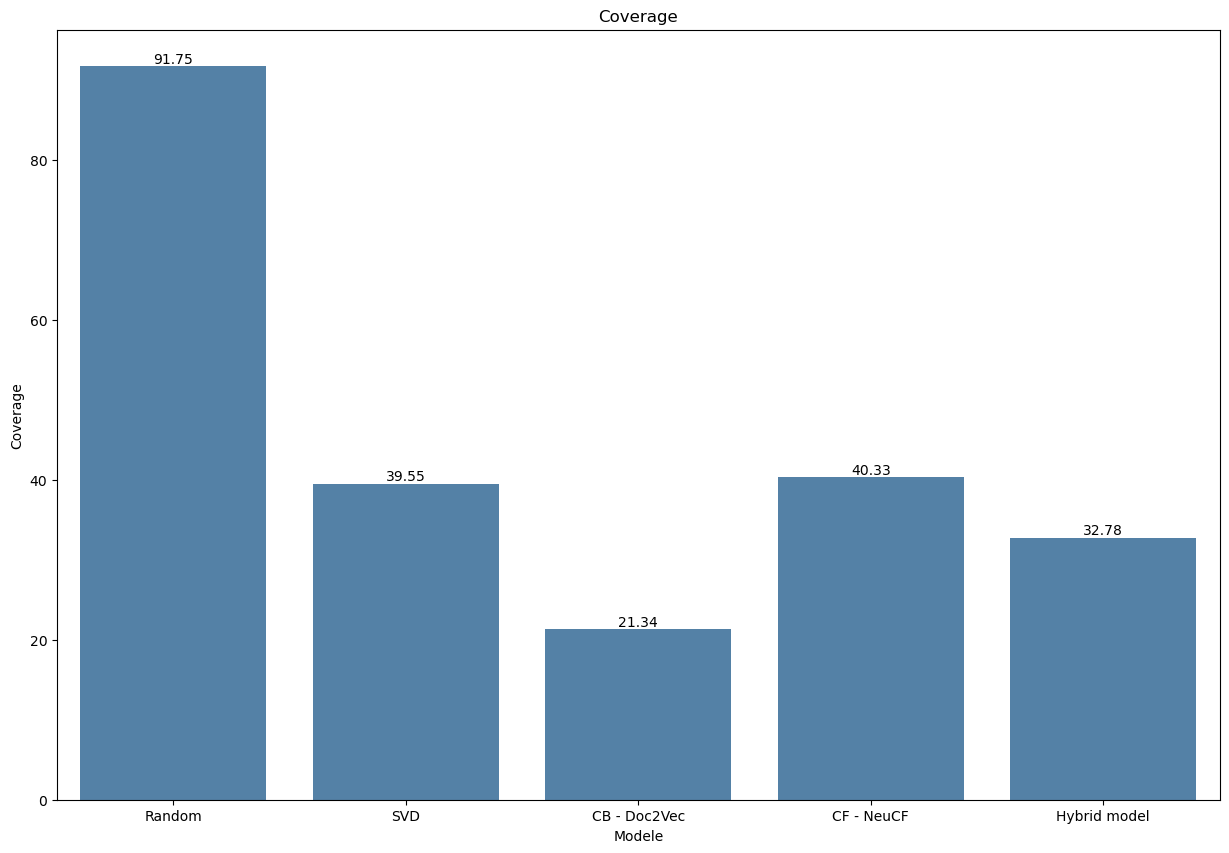

In [250]:
# Do rysowania wykresów usuwanie wyników modelu popularnościowego, przeszkadzającego w porównywniu innych modeli.
evaluation_df_for_plot = evaluation_df.drop('Popularity')

for col_name in evaluation_df_for_plot.columns:
    column_name = col_name
    #sns.set(style="whitegrid")
    #sns.set_palette("steelblue")
    ax = sns.barplot(x=evaluation_df_for_plot.index, y=column_name, data=evaluation_df_for_plot, color='steelblue')
    ax.set_xticklabels(ax.get_xticklabels())
    for i, v in enumerate(evaluation_df_for_plot[column_name]):
        ax.text(i, v, str(v), ha='center', va='bottom')
    plt.title(column_name)
    plt.xlabel('Modele')
    #plt.ylabel(column_name)
    plt.show()